In [1]:
# Setup and Imports

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Data Augmentation Setup

# Enhanced Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [3]:
# Cutmix and Mixup Implementation

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    # Random box coordinates
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    # Adjust lambda to be the ratio of box size
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int_(W * cut_rat)
    cut_h = np.int_(H * cut_rat)

    # Uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [4]:
# Load CIFAR-10 Dataset

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 128

# Adjust workers based on system's performance characteristics
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, 
                         num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, 
                       num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Model Definition - Spatial Attention Module

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Generate spatial attention map
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(attention)
        attention = self.sigmoid(attention)
        
        return x * attention

In [6]:
# Model Definition - Attention Residual Block

class AttentionResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(AttentionResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        reduction = max(out_channels // 16, 4)  # Ensure at least 4 channels
        self.channel_attention = nn.Sequential(
            nn.Conv2d(out_channels, out_channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // reduction, out_channels, 1, bias=False),
            nn.Sigmoid()
        )
        
        # Spatial attention
        self.spatial_attention = SpatialAttention(kernel_size=7)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Channel attention
        avg_out = self.channel_attention(self.avg_pool(out))
        max_out = self.channel_attention(self.max_pool(out))
        out = out * (avg_out + max_out)
        
        # Spatial attention
        out = self.spatial_attention(out)
        
        # Residual connection
        identity = self.shortcut(identity)
        out += identity
        out = self.relu(out)
        
        return out

In [7]:
# Model Definition - Enhanced Efficient ResNet Architecture

class EnhancedEfficientResNet(nn.Module):
    def __init__(self, num_classes=10, base_width=31):  # Keep at 31
        super(EnhancedEfficientResNet, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, base_width, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(base_width)
        self.relu = nn.ReLU(inplace=True)
        
        # Layer configurations (slightly modified)
        self.layer1 = self._make_layer(base_width, base_width*2, 2, stride=1)
        self.layer2 = self._make_layer(base_width*2, base_width*4, 2, stride=2)
        self.layer3 = self._make_layer(base_width*4, base_width*8, 2, stride=2)
        self.layer4 = self._make_layer(base_width*8, base_width*8, 2, stride=1)
        
        # Additional small layer to fine-tune parameter count
        self.extra_conv = nn.Conv2d(base_width*8, base_width*8, kernel_size=1, bias=False)
        self.extra_bn = nn.BatchNorm2d(base_width*8)
        
        # Global pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(base_width*8, num_classes)
        
        # Weight initialization
        self._initialize_weights()
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [
            AttentionResidualBlock(in_channels, out_channels, stride)
        ]
        
        for _ in range(1, blocks):
            layers.append(
                AttentionResidualBlock(out_channels, out_channels)
            )
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Apply the extra convolution
        x = self.extra_conv(x)
        x = self.extra_bn(x)
        x = self.relu(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
    
        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:
# Exponential Moving Average Implementation

class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        # Register model parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = self.decay * self.shadow[name] + (1.0 - self.decay) * param.data
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

In [9]:
# Training Function

def train_model(model, train_loader, val_loader, num_epochs=500):
    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Optimizer with weight decay - starting with same lr as your original code
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, 
                          weight_decay=5e-4, nesterov=True)
    
    # Standard cosine annealing without restarts - more like your original code
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Initialize EMA model
    ema = EMA(model, decay=0.999)
    
    # Mixed precision training
    scaler = GradScaler()
    
    best_val_acc = 0.0
    best_model_state = None
    best_ema_state = None
    
    # Training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # Mixup and Cutmix probabilities
    mixup_prob = 0.3
    cutmix_prob = 0.3
    mixup_alpha = 1.0
    cutmix_alpha = 1.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Apply mixup or cutmix with probability
            r = np.random.rand()
            if r < mixup_prob:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, mixup_alpha)
                mixed = True
            elif r < mixup_prob + cutmix_prob:
                inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, cutmix_alpha)
                mixed = True
            else:
                mixed = False
            
            # Mixed precision training
            with autocast():
                optimizer.zero_grad()
                outputs = model(inputs)
                
                if mixed:
                    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                else:
                    loss = criterion(outputs, targets)
            
            # Scale gradients and optimize
            scaler.scale(loss).backward()
            
            # Gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            # Update EMA model
            ema.update()
            
            # MPS memory management
            if device == 'mps' and (progress_bar.n + 1) % 10 == 0:
                torch.mps.empty_cache()
            
            train_loss += loss.item()
            
            # Calculate accuracy (with original targets if using mixup/cutmix)
            if not mixed:
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            else:
                # Approximate accuracy for mixed samples
                _, predicted = outputs.max(1)
                total += targets.size(0)
                # For mixup/cutmix, use original targets for progress display
                correct += (lam * predicted.eq(targets_a).sum().item() + 
                           (1 - lam) * predicted.eq(targets_b).sum().item())
            
            progress_bar.set_postfix({
                'loss': train_loss / (progress_bar.n + 1),
                'acc': 100. * correct / total if total > 0 else 0.0,
                'lr': optimizer.param_groups[0]['lr']
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total if total > 0 else 0.0
        
        # Validation phase - use EMA model
        ema.apply_shadow()
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # Restore original model
        ema.restore()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            # Also save EMA state
            ema.apply_shadow()
            best_ema_state = {k: v.clone() for k, v in model.state_dict().items()}
            ema.restore()
            
            # Save both models
            torch.save(best_model_state, 'best_model.pth')
            torch.save(best_ema_state, 'best_ema_model.pth')
            print(f"Best model saved with validation accuracy: {best_val_acc:.2f}%")
        
        scheduler.step()
    
    # Load best model weights for evaluation
    model.load_state_dict(best_ema_state)  # Use EMA model for final evaluation
    return model, best_val_acc, history


In [10]:
# Generate Submission File

def create_submission(model, test_loader, filename="submission.csv"):
    model.eval()
    all_predictions = []
    
    with torch.no_grad():
        for inputs, _ in tqdm(test_loader, desc="Generating predictions"):
            inputs = inputs.to(device)
            
            # Test time augmentation - average predictions from different transforms
            outputs = model(inputs)
            
            # Add horizontal flip augmentation
            flipped_inputs = torch.flip(inputs, dims=[3])
            flipped_outputs = model(flipped_inputs)
            
            # Average predictions
            avg_outputs = (outputs + flipped_outputs) / 2.0
            
            _, predictions = avg_outputs.max(1)
            all_predictions.extend(predictions.cpu().numpy())
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'ID': range(len(all_predictions)),
        'Labels': all_predictions
    })
    
    submission_df.to_csv(filename, index=False)
    print(f"Submission file created: {filename}")
    return submission_df


In [11]:
# Plot Training History

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [12]:
# Main Execution Function

def main():
    # Create model
    model = EnhancedEfficientResNet(num_classes=10)
    param_count = model.count_parameters()
    print(f"Model parameters: {param_count:,}")
    
    # Check parameter count against limit
    if param_count > 5_000_000:
        print(f"WARNING: Model exceeds 5M parameter limit by {param_count - 5_000_000:,}")
    else:
        print(f"Model is within the 5M parameter limit (remaining: {5_000_000 - param_count:,})")
    
    # Move model to device
    model = model.to(device)
    
    # Train model
    model, best_val_acc, history = train_model(model, train_loader, val_loader, num_epochs=500)
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    
    # Plot training history
    plot_history(history)
    
    # Create submission file
    create_submission(model, test_loader, "submission.csv")

Model parameters: 4,913,705
Model is within the 5M parameter limit (remaining: 86,295)


/tmp/ipykernel_5387/3308719676.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/500:   0%|          | 0/352 [00:00<?, ?it/s]/tmp/ipykernel_5387/3308719676.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/500: 100%|██████████| 352/352 [00:23<00:00, 15.17it/s, loss=1.93, acc=34.7, lr=0.1]


Epoch 1/500, Train Loss: 1.9220, Train Acc: 34.73%, Val Loss: 2.6621, Val Acc: 9.82%
Best model saved with validation accuracy: 9.82%


Epoch 2/500: 100%|██████████| 352/352 [00:19<00:00, 18.43it/s, loss=1.7, acc=47.2, lr=0.1] 


Epoch 2/500, Train Loss: 1.6952, Train Acc: 47.21%, Val Loss: 4.7557, Val Acc: 9.76%


Epoch 3/500: 100%|██████████| 352/352 [00:19<00:00, 18.34it/s, loss=1.61, acc=52.5, lr=0.1]


Epoch 3/500, Train Loss: 1.6052, Train Acc: 52.47%, Val Loss: 6.3740, Val Acc: 12.82%
Best model saved with validation accuracy: 12.82%


Epoch 4/500: 100%|██████████| 352/352 [00:19<00:00, 18.35it/s, loss=1.54, acc=55.5, lr=0.1]


Epoch 4/500, Train Loss: 1.5421, Train Acc: 55.53%, Val Loss: 10.2978, Val Acc: 12.98%
Best model saved with validation accuracy: 12.98%


Epoch 5/500: 100%|██████████| 352/352 [00:19<00:00, 18.36it/s, loss=1.49, acc=58.3, lr=0.1]


Epoch 5/500, Train Loss: 1.4926, Train Acc: 58.30%, Val Loss: 11.7398, Val Acc: 17.06%
Best model saved with validation accuracy: 17.06%


Epoch 6/500: 100%|██████████| 352/352 [00:19<00:00, 18.41it/s, loss=1.49, acc=58.4, lr=0.1]


Epoch 6/500, Train Loss: 1.4927, Train Acc: 58.43%, Val Loss: 16.7774, Val Acc: 18.04%
Best model saved with validation accuracy: 18.04%


Epoch 7/500: 100%|██████████| 352/352 [00:19<00:00, 18.26it/s, loss=1.47, acc=60.1, lr=0.1]


Epoch 7/500, Train Loss: 1.4646, Train Acc: 60.15%, Val Loss: 10.7644, Val Acc: 27.44%
Best model saved with validation accuracy: 27.44%


Epoch 8/500: 100%|██████████| 352/352 [00:19<00:00, 18.33it/s, loss=1.47, acc=60.3, lr=0.1]


Epoch 8/500, Train Loss: 1.4584, Train Acc: 60.31%, Val Loss: 9.4934, Val Acc: 33.44%
Best model saved with validation accuracy: 33.44%


Epoch 9/500: 100%|██████████| 352/352 [00:19<00:00, 18.12it/s, loss=1.42, acc=62.5, lr=0.0999]


Epoch 9/500, Train Loss: 1.4103, Train Acc: 62.47%, Val Loss: 5.6864, Val Acc: 43.50%
Best model saved with validation accuracy: 43.50%


Epoch 10/500: 100%|██████████| 352/352 [00:19<00:00, 17.96it/s, loss=1.41, acc=62.7, lr=0.0999]


Epoch 10/500, Train Loss: 1.4100, Train Acc: 62.70%, Val Loss: 5.2032, Val Acc: 47.60%
Best model saved with validation accuracy: 47.60%


Epoch 11/500: 100%|██████████| 352/352 [00:19<00:00, 18.18it/s, loss=1.41, acc=62.9, lr=0.0999]


Epoch 11/500, Train Loss: 1.4129, Train Acc: 62.93%, Val Loss: 2.8120, Val Acc: 57.16%
Best model saved with validation accuracy: 57.16%


Epoch 12/500: 100%|██████████| 352/352 [00:19<00:00, 18.48it/s, loss=1.41, acc=63.2, lr=0.0999]


Epoch 12/500, Train Loss: 1.3997, Train Acc: 63.21%, Val Loss: 2.3653, Val Acc: 64.90%
Best model saved with validation accuracy: 64.90%


Epoch 13/500: 100%|██████████| 352/352 [00:18<00:00, 18.59it/s, loss=1.36, acc=64.9, lr=0.0999]


Epoch 13/500, Train Loss: 1.3596, Train Acc: 64.93%, Val Loss: 1.7745, Val Acc: 63.00%


Epoch 14/500: 100%|██████████| 352/352 [00:19<00:00, 18.17it/s, loss=1.35, acc=65.6, lr=0.0998]


Epoch 14/500, Train Loss: 1.3512, Train Acc: 65.63%, Val Loss: 1.2907, Val Acc: 71.04%
Best model saved with validation accuracy: 71.04%


Epoch 15/500: 100%|██████████| 352/352 [00:19<00:00, 17.91it/s, loss=1.37, acc=64.5, lr=0.0998]


Epoch 15/500, Train Loss: 1.3673, Train Acc: 64.53%, Val Loss: 1.2341, Val Acc: 72.16%
Best model saved with validation accuracy: 72.16%


Epoch 16/500: 100%|██████████| 352/352 [00:19<00:00, 18.49it/s, loss=1.37, acc=64.9, lr=0.0998]


Epoch 16/500, Train Loss: 1.3646, Train Acc: 64.87%, Val Loss: 1.2543, Val Acc: 70.06%


Epoch 17/500: 100%|██████████| 352/352 [00:18<00:00, 18.64it/s, loss=1.31, acc=67.3, lr=0.0997]


Epoch 17/500, Train Loss: 1.3045, Train Acc: 67.34%, Val Loss: 1.3232, Val Acc: 67.44%


Epoch 18/500: 100%|██████████| 352/352 [00:18<00:00, 18.72it/s, loss=1.32, acc=66.9, lr=0.0997]


Epoch 18/500, Train Loss: 1.3174, Train Acc: 66.91%, Val Loss: 1.0089, Val Acc: 78.60%
Best model saved with validation accuracy: 78.60%


Epoch 19/500: 100%|██████████| 352/352 [00:19<00:00, 18.52it/s, loss=1.35, acc=65.6, lr=0.0997]


Epoch 19/500, Train Loss: 1.3538, Train Acc: 65.55%, Val Loss: 1.0866, Val Acc: 75.72%


Epoch 20/500: 100%|██████████| 352/352 [00:18<00:00, 18.82it/s, loss=1.37, acc=64.7, lr=0.0996]


Epoch 20/500, Train Loss: 1.3669, Train Acc: 64.70%, Val Loss: 0.9491, Val Acc: 80.80%
Best model saved with validation accuracy: 80.80%


Epoch 21/500: 100%|██████████| 352/352 [00:18<00:00, 18.55it/s, loss=1.32, acc=67.4, lr=0.0996]


Epoch 21/500, Train Loss: 1.3135, Train Acc: 67.42%, Val Loss: 1.0377, Val Acc: 76.90%


Epoch 22/500: 100%|██████████| 352/352 [00:18<00:00, 18.63it/s, loss=1.35, acc=66, lr=0.0996]  


Epoch 22/500, Train Loss: 1.3430, Train Acc: 65.96%, Val Loss: 0.9606, Val Acc: 80.10%


Epoch 23/500: 100%|██████████| 352/352 [00:18<00:00, 18.65it/s, loss=1.35, acc=65.5, lr=0.0995]


Epoch 23/500, Train Loss: 1.3537, Train Acc: 65.54%, Val Loss: 0.9031, Val Acc: 82.96%
Best model saved with validation accuracy: 82.96%


Epoch 24/500: 100%|██████████| 352/352 [00:18<00:00, 18.53it/s, loss=1.35, acc=66.1, lr=0.0995]


Epoch 24/500, Train Loss: 1.3424, Train Acc: 66.14%, Val Loss: 1.1092, Val Acc: 73.40%


Epoch 25/500: 100%|██████████| 352/352 [00:18<00:00, 18.57it/s, loss=1.34, acc=66.2, lr=0.0994]


Epoch 25/500, Train Loss: 1.3369, Train Acc: 66.21%, Val Loss: 1.0179, Val Acc: 78.76%


Epoch 26/500: 100%|██████████| 352/352 [00:18<00:00, 18.65it/s, loss=1.3, acc=68.1, lr=0.0994] 


Epoch 26/500, Train Loss: 1.2990, Train Acc: 68.12%, Val Loss: 0.9430, Val Acc: 80.54%


Epoch 27/500: 100%|██████████| 352/352 [00:18<00:00, 18.61it/s, loss=1.34, acc=66.1, lr=0.0993]


Epoch 27/500, Train Loss: 1.3364, Train Acc: 66.06%, Val Loss: 1.0635, Val Acc: 77.22%


Epoch 28/500: 100%|██████████| 352/352 [00:19<00:00, 18.32it/s, loss=1.33, acc=67, lr=0.0993]  


Epoch 28/500, Train Loss: 1.3235, Train Acc: 66.96%, Val Loss: 0.8776, Val Acc: 83.48%
Best model saved with validation accuracy: 83.48%


Epoch 29/500: 100%|██████████| 352/352 [00:18<00:00, 18.67it/s, loss=1.29, acc=68.6, lr=0.0992]


Epoch 29/500, Train Loss: 1.2872, Train Acc: 68.61%, Val Loss: 1.0201, Val Acc: 78.80%


Epoch 30/500: 100%|██████████| 352/352 [00:18<00:00, 18.79it/s, loss=1.32, acc=67.1, lr=0.0992]


Epoch 30/500, Train Loss: 1.3169, Train Acc: 67.10%, Val Loss: 0.8728, Val Acc: 84.74%
Best model saved with validation accuracy: 84.74%


Epoch 31/500: 100%|██████████| 352/352 [00:18<00:00, 18.64it/s, loss=1.32, acc=66.9, lr=0.0991]


Epoch 31/500, Train Loss: 1.3202, Train Acc: 66.89%, Val Loss: 1.0236, Val Acc: 79.40%


Epoch 32/500: 100%|██████████| 352/352 [00:18<00:00, 18.71it/s, loss=1.37, acc=64.8, lr=0.0991]


Epoch 32/500, Train Loss: 1.3697, Train Acc: 64.80%, Val Loss: 1.0245, Val Acc: 78.00%


Epoch 33/500: 100%|██████████| 352/352 [00:18<00:00, 18.58it/s, loss=1.32, acc=67.5, lr=0.099]


Epoch 33/500, Train Loss: 1.3117, Train Acc: 67.46%, Val Loss: 0.9412, Val Acc: 82.76%


Epoch 34/500: 100%|██████████| 352/352 [00:18<00:00, 18.61it/s, loss=1.33, acc=66.3, lr=0.0989]


Epoch 34/500, Train Loss: 1.3300, Train Acc: 66.30%, Val Loss: 0.9641, Val Acc: 79.78%


Epoch 35/500: 100%|██████████| 352/352 [00:18<00:00, 18.90it/s, loss=1.3, acc=68, lr=0.0989]   


Epoch 35/500, Train Loss: 1.3008, Train Acc: 68.01%, Val Loss: 0.8623, Val Acc: 84.94%
Best model saved with validation accuracy: 84.94%


Epoch 36/500: 100%|██████████| 352/352 [00:18<00:00, 18.89it/s, loss=1.32, acc=67.5, lr=0.0988]


Epoch 36/500, Train Loss: 1.3171, Train Acc: 67.47%, Val Loss: 0.9212, Val Acc: 82.12%


Epoch 37/500: 100%|██████████| 352/352 [00:18<00:00, 18.76it/s, loss=1.32, acc=67.4, lr=0.0987]


Epoch 37/500, Train Loss: 1.3181, Train Acc: 67.36%, Val Loss: 0.8917, Val Acc: 82.84%


Epoch 38/500: 100%|██████████| 352/352 [00:18<00:00, 18.95it/s, loss=1.33, acc=66.7, lr=0.0987]


Epoch 38/500, Train Loss: 1.3275, Train Acc: 66.74%, Val Loss: 0.8674, Val Acc: 85.76%
Best model saved with validation accuracy: 85.76%


Epoch 39/500: 100%|██████████| 352/352 [00:18<00:00, 19.02it/s, loss=1.29, acc=68.2, lr=0.0986]


Epoch 39/500, Train Loss: 1.2926, Train Acc: 68.17%, Val Loss: 0.8486, Val Acc: 85.44%


Epoch 40/500: 100%|██████████| 352/352 [00:18<00:00, 18.87it/s, loss=1.3, acc=68.3, lr=0.0985] 


Epoch 40/500, Train Loss: 1.2895, Train Acc: 68.30%, Val Loss: 0.9703, Val Acc: 80.30%


Epoch 41/500: 100%|██████████| 352/352 [00:18<00:00, 18.91it/s, loss=1.32, acc=67, lr=0.0984]  


Epoch 41/500, Train Loss: 1.3174, Train Acc: 67.00%, Val Loss: 0.9717, Val Acc: 81.74%


Epoch 42/500: 100%|██████████| 352/352 [00:18<00:00, 19.05it/s, loss=1.33, acc=66.8, lr=0.0984]


Epoch 42/500, Train Loss: 1.3265, Train Acc: 66.83%, Val Loss: 0.8612, Val Acc: 85.12%


Epoch 43/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.27, acc=69.5, lr=0.0983]


Epoch 43/500, Train Loss: 1.2601, Train Acc: 69.46%, Val Loss: 0.8266, Val Acc: 86.98%
Best model saved with validation accuracy: 86.98%


Epoch 44/500: 100%|██████████| 352/352 [00:18<00:00, 19.23it/s, loss=1.27, acc=69.2, lr=0.0982]


Epoch 44/500, Train Loss: 1.2683, Train Acc: 69.17%, Val Loss: 0.8396, Val Acc: 85.36%


Epoch 45/500: 100%|██████████| 352/352 [00:18<00:00, 19.18it/s, loss=1.27, acc=69.8, lr=0.0981]


Epoch 45/500, Train Loss: 1.2602, Train Acc: 69.75%, Val Loss: 0.8796, Val Acc: 84.82%


Epoch 46/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.33, acc=66.6, lr=0.098]


Epoch 46/500, Train Loss: 1.3262, Train Acc: 66.58%, Val Loss: 0.9308, Val Acc: 83.48%


Epoch 47/500: 100%|██████████| 352/352 [00:18<00:00, 19.26it/s, loss=1.3, acc=67.9, lr=0.0979] 


Epoch 47/500, Train Loss: 1.2997, Train Acc: 67.94%, Val Loss: 0.9549, Val Acc: 81.90%


Epoch 48/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.27, acc=69.4, lr=0.0978]


Epoch 48/500, Train Loss: 1.2661, Train Acc: 69.37%, Val Loss: 0.8399, Val Acc: 85.06%


Epoch 49/500: 100%|██████████| 352/352 [00:18<00:00, 18.95it/s, loss=1.29, acc=68.3, lr=0.0977]


Epoch 49/500, Train Loss: 1.2949, Train Acc: 68.28%, Val Loss: 0.9254, Val Acc: 82.64%


Epoch 50/500: 100%|██████████| 352/352 [00:18<00:00, 19.15it/s, loss=1.28, acc=69.1, lr=0.0976]


Epoch 50/500, Train Loss: 1.2750, Train Acc: 69.09%, Val Loss: 0.8895, Val Acc: 82.98%


Epoch 51/500: 100%|██████████| 352/352 [00:18<00:00, 19.02it/s, loss=1.3, acc=67.9, lr=0.0976] 


Epoch 51/500, Train Loss: 1.2985, Train Acc: 67.90%, Val Loss: 0.8420, Val Acc: 85.54%


Epoch 52/500: 100%|██████████| 352/352 [00:18<00:00, 19.15it/s, loss=1.28, acc=68.7, lr=0.0975]


Epoch 52/500, Train Loss: 1.2779, Train Acc: 68.68%, Val Loss: 0.8663, Val Acc: 84.92%


Epoch 53/500: 100%|██████████| 352/352 [00:18<00:00, 19.24it/s, loss=1.25, acc=70.1, lr=0.0974]


Epoch 53/500, Train Loss: 1.2511, Train Acc: 70.11%, Val Loss: 0.9309, Val Acc: 82.32%


Epoch 54/500: 100%|██████████| 352/352 [00:18<00:00, 18.86it/s, loss=1.32, acc=67.2, lr=0.0973]


Epoch 54/500, Train Loss: 1.3187, Train Acc: 67.22%, Val Loss: 0.9843, Val Acc: 79.80%


Epoch 55/500: 100%|██████████| 352/352 [00:18<00:00, 19.05it/s, loss=1.32, acc=66.9, lr=0.0971]


Epoch 55/500, Train Loss: 1.3165, Train Acc: 66.92%, Val Loss: 1.0017, Val Acc: 78.44%


Epoch 56/500: 100%|██████████| 352/352 [00:18<00:00, 19.16it/s, loss=1.29, acc=68.5, lr=0.097]


Epoch 56/500, Train Loss: 1.2801, Train Acc: 68.53%, Val Loss: 0.8485, Val Acc: 85.44%


Epoch 57/500: 100%|██████████| 352/352 [00:18<00:00, 18.87it/s, loss=1.25, acc=70, lr=0.0969]  


Epoch 57/500, Train Loss: 1.2473, Train Acc: 70.04%, Val Loss: 0.9652, Val Acc: 81.08%


Epoch 58/500: 100%|██████████| 352/352 [00:18<00:00, 19.12it/s, loss=1.28, acc=68.6, lr=0.0968]


Epoch 58/500, Train Loss: 1.2780, Train Acc: 68.63%, Val Loss: 0.8752, Val Acc: 84.26%


Epoch 59/500: 100%|██████████| 352/352 [00:18<00:00, 18.98it/s, loss=1.28, acc=68.8, lr=0.0967]


Epoch 59/500, Train Loss: 1.2787, Train Acc: 68.79%, Val Loss: 0.9376, Val Acc: 81.92%


Epoch 60/500: 100%|██████████| 352/352 [00:18<00:00, 19.18it/s, loss=1.28, acc=68.6, lr=0.0966]


Epoch 60/500, Train Loss: 1.2822, Train Acc: 68.63%, Val Loss: 0.9245, Val Acc: 82.28%


Epoch 61/500: 100%|██████████| 352/352 [00:18<00:00, 19.03it/s, loss=1.29, acc=68.9, lr=0.0965]


Epoch 61/500, Train Loss: 1.2792, Train Acc: 68.90%, Val Loss: 0.8979, Val Acc: 83.72%


Epoch 62/500: 100%|██████████| 352/352 [00:18<00:00, 18.94it/s, loss=1.27, acc=69.3, lr=0.0964]


Epoch 62/500, Train Loss: 1.2701, Train Acc: 69.34%, Val Loss: 0.9389, Val Acc: 81.66%


Epoch 63/500: 100%|██████████| 352/352 [00:18<00:00, 18.90it/s, loss=1.27, acc=69.1, lr=0.0963]


Epoch 63/500, Train Loss: 1.2722, Train Acc: 69.15%, Val Loss: 0.9842, Val Acc: 81.68%


Epoch 64/500: 100%|██████████| 352/352 [00:18<00:00, 19.16it/s, loss=1.26, acc=69.3, lr=0.0961]


Epoch 64/500, Train Loss: 1.2607, Train Acc: 69.34%, Val Loss: 0.9098, Val Acc: 83.52%


Epoch 65/500: 100%|██████████| 352/352 [00:18<00:00, 19.13it/s, loss=1.26, acc=69.4, lr=0.096]


Epoch 65/500, Train Loss: 1.2599, Train Acc: 69.36%, Val Loss: 0.8236, Val Acc: 87.20%
Best model saved with validation accuracy: 87.20%


Epoch 66/500: 100%|██████████| 352/352 [00:18<00:00, 18.82it/s, loss=1.27, acc=69.3, lr=0.0959]


Epoch 66/500, Train Loss: 1.2615, Train Acc: 69.33%, Val Loss: 0.8927, Val Acc: 86.26%


Epoch 67/500: 100%|██████████| 352/352 [00:18<00:00, 19.25it/s, loss=1.23, acc=70.5, lr=0.0958]


Epoch 67/500, Train Loss: 1.2337, Train Acc: 70.53%, Val Loss: 0.9083, Val Acc: 82.54%


Epoch 68/500: 100%|██████████| 352/352 [00:18<00:00, 19.08it/s, loss=1.26, acc=69.5, lr=0.0956]


Epoch 68/500, Train Loss: 1.2561, Train Acc: 69.52%, Val Loss: 0.8421, Val Acc: 86.06%


Epoch 69/500: 100%|██████████| 352/352 [00:18<00:00, 19.18it/s, loss=1.32, acc=66.8, lr=0.0955]


Epoch 69/500, Train Loss: 1.3201, Train Acc: 66.77%, Val Loss: 0.9387, Val Acc: 82.12%


Epoch 70/500: 100%|██████████| 352/352 [00:18<00:00, 19.20it/s, loss=1.26, acc=69.4, lr=0.0954]


Epoch 70/500, Train Loss: 1.2593, Train Acc: 69.36%, Val Loss: 0.9035, Val Acc: 84.64%


Epoch 71/500: 100%|██████████| 352/352 [00:18<00:00, 19.25it/s, loss=1.27, acc=69, lr=0.0952]  


Epoch 71/500, Train Loss: 1.2692, Train Acc: 69.01%, Val Loss: 0.9275, Val Acc: 83.94%


Epoch 72/500: 100%|██████████| 352/352 [00:18<00:00, 18.95it/s, loss=1.28, acc=68.7, lr=0.0951]


Epoch 72/500, Train Loss: 1.2745, Train Acc: 68.68%, Val Loss: 0.9258, Val Acc: 86.14%


Epoch 73/500: 100%|██████████| 352/352 [00:18<00:00, 18.91it/s, loss=1.27, acc=69.1, lr=0.095]


Epoch 73/500, Train Loss: 1.2697, Train Acc: 69.11%, Val Loss: 0.9465, Val Acc: 84.10%


Epoch 74/500: 100%|██████████| 352/352 [00:18<00:00, 19.23it/s, loss=1.25, acc=69.6, lr=0.0948]


Epoch 74/500, Train Loss: 1.2505, Train Acc: 69.58%, Val Loss: 0.8250, Val Acc: 86.50%


Epoch 75/500: 100%|██████████| 352/352 [00:19<00:00, 17.92it/s, loss=1.27, acc=68.8, lr=0.0947]


Epoch 75/500, Train Loss: 1.2661, Train Acc: 68.85%, Val Loss: 0.9222, Val Acc: 83.28%


Epoch 76/500: 100%|██████████| 352/352 [00:20<00:00, 17.39it/s, loss=1.3, acc=67.7, lr=0.0946] 


Epoch 76/500, Train Loss: 1.2949, Train Acc: 67.75%, Val Loss: 0.9128, Val Acc: 83.40%


Epoch 77/500: 100%|██████████| 352/352 [00:19<00:00, 18.17it/s, loss=1.28, acc=69, lr=0.0944]  


Epoch 77/500, Train Loss: 1.2696, Train Acc: 69.00%, Val Loss: 0.8919, Val Acc: 84.12%


Epoch 78/500: 100%|██████████| 352/352 [00:18<00:00, 19.24it/s, loss=1.26, acc=69.3, lr=0.0943]


Epoch 78/500, Train Loss: 1.2589, Train Acc: 69.34%, Val Loss: 0.9007, Val Acc: 83.06%


Epoch 79/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.25, acc=69.4, lr=0.0941]


Epoch 79/500, Train Loss: 1.2477, Train Acc: 69.43%, Val Loss: 0.9559, Val Acc: 82.00%


Epoch 80/500: 100%|██████████| 352/352 [00:18<00:00, 19.22it/s, loss=1.25, acc=69.9, lr=0.094]


Epoch 80/500, Train Loss: 1.2451, Train Acc: 69.86%, Val Loss: 0.9030, Val Acc: 86.18%


Epoch 81/500: 100%|██████████| 352/352 [00:18<00:00, 19.12it/s, loss=1.23, acc=70.5, lr=0.0938]


Epoch 81/500, Train Loss: 1.2285, Train Acc: 70.49%, Val Loss: 0.8531, Val Acc: 86.54%


Epoch 82/500: 100%|██████████| 352/352 [00:18<00:00, 19.21it/s, loss=1.32, acc=66.7, lr=0.0937]


Epoch 82/500, Train Loss: 1.3159, Train Acc: 66.70%, Val Loss: 0.8948, Val Acc: 84.42%


Epoch 83/500: 100%|██████████| 352/352 [00:18<00:00, 19.06it/s, loss=1.27, acc=68.7, lr=0.0935]


Epoch 83/500, Train Loss: 1.2706, Train Acc: 68.72%, Val Loss: 0.9113, Val Acc: 82.28%


Epoch 84/500: 100%|██████████| 352/352 [00:18<00:00, 18.99it/s, loss=1.26, acc=69.3, lr=0.0934]


Epoch 84/500, Train Loss: 1.2614, Train Acc: 69.33%, Val Loss: 0.8653, Val Acc: 86.20%


Epoch 85/500: 100%|██████████| 352/352 [00:18<00:00, 19.12it/s, loss=1.27, acc=68.6, lr=0.0932]


Epoch 85/500, Train Loss: 1.2722, Train Acc: 68.60%, Val Loss: 0.8538, Val Acc: 85.98%


Epoch 86/500: 100%|██████████| 352/352 [00:18<00:00, 19.03it/s, loss=1.26, acc=69.7, lr=0.093]


Epoch 86/500, Train Loss: 1.2523, Train Acc: 69.67%, Val Loss: 0.8952, Val Acc: 83.54%


Epoch 87/500: 100%|██████████| 352/352 [00:18<00:00, 19.06it/s, loss=1.27, acc=69.1, lr=0.0929]


Epoch 87/500, Train Loss: 1.2651, Train Acc: 69.06%, Val Loss: 0.8648, Val Acc: 85.74%


Epoch 88/500: 100%|██████████| 352/352 [00:18<00:00, 19.07it/s, loss=1.25, acc=70, lr=0.0927]  


Epoch 88/500, Train Loss: 1.2459, Train Acc: 70.03%, Val Loss: 0.8986, Val Acc: 82.82%


Epoch 89/500: 100%|██████████| 352/352 [00:18<00:00, 19.17it/s, loss=1.25, acc=70.1, lr=0.0925]


Epoch 89/500, Train Loss: 1.2456, Train Acc: 70.07%, Val Loss: 1.1793, Val Acc: 72.52%


Epoch 90/500: 100%|██████████| 352/352 [00:18<00:00, 19.20it/s, loss=1.26, acc=69.7, lr=0.0924]


Epoch 90/500, Train Loss: 1.2548, Train Acc: 69.69%, Val Loss: 0.8938, Val Acc: 84.76%


Epoch 91/500: 100%|██████████| 352/352 [00:18<00:00, 19.12it/s, loss=1.27, acc=69.3, lr=0.0922]


Epoch 91/500, Train Loss: 1.2622, Train Acc: 69.27%, Val Loss: 0.9171, Val Acc: 85.62%


Epoch 92/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.25, acc=69.8, lr=0.092]


Epoch 92/500, Train Loss: 1.2467, Train Acc: 69.81%, Val Loss: 0.8992, Val Acc: 84.84%


Epoch 93/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.28, acc=68.7, lr=0.0919]


Epoch 93/500, Train Loss: 1.2727, Train Acc: 68.72%, Val Loss: 0.8557, Val Acc: 87.34%
Best model saved with validation accuracy: 87.34%


Epoch 94/500: 100%|██████████| 352/352 [00:18<00:00, 19.09it/s, loss=1.26, acc=69.5, lr=0.0917]


Epoch 94/500, Train Loss: 1.2550, Train Acc: 69.49%, Val Loss: 0.9364, Val Acc: 82.24%


Epoch 95/500: 100%|██████████| 352/352 [00:18<00:00, 19.20it/s, loss=1.31, acc=67.1, lr=0.0915]


Epoch 95/500, Train Loss: 1.3051, Train Acc: 67.08%, Val Loss: 0.8337, Val Acc: 88.88%
Best model saved with validation accuracy: 88.88%


Epoch 96/500: 100%|██████████| 352/352 [00:18<00:00, 19.15it/s, loss=1.27, acc=68.9, lr=0.0914]


Epoch 96/500, Train Loss: 1.2742, Train Acc: 68.85%, Val Loss: 0.9183, Val Acc: 83.26%


Epoch 97/500: 100%|██████████| 352/352 [00:18<00:00, 19.07it/s, loss=1.26, acc=69.8, lr=0.0912]


Epoch 97/500, Train Loss: 1.2502, Train Acc: 69.81%, Val Loss: 0.9757, Val Acc: 81.26%


Epoch 98/500: 100%|██████████| 352/352 [00:18<00:00, 19.24it/s, loss=1.27, acc=68.9, lr=0.091]


Epoch 98/500, Train Loss: 1.2677, Train Acc: 68.93%, Val Loss: 0.8703, Val Acc: 85.58%


Epoch 99/500: 100%|██████████| 352/352 [00:18<00:00, 19.17it/s, loss=1.25, acc=69.8, lr=0.0908]


Epoch 99/500, Train Loss: 1.2477, Train Acc: 69.79%, Val Loss: 0.8921, Val Acc: 84.46%


Epoch 100/500: 100%|██████████| 352/352 [00:18<00:00, 19.09it/s, loss=1.25, acc=70.1, lr=0.0906]


Epoch 100/500, Train Loss: 1.2452, Train Acc: 70.12%, Val Loss: 0.8644, Val Acc: 85.16%


Epoch 101/500: 100%|██████████| 352/352 [00:18<00:00, 19.11it/s, loss=1.25, acc=69.9, lr=0.0905]


Epoch 101/500, Train Loss: 1.2494, Train Acc: 69.89%, Val Loss: 0.9480, Val Acc: 83.40%


Epoch 102/500: 100%|██████████| 352/352 [00:18<00:00, 19.18it/s, loss=1.23, acc=70.6, lr=0.0903]


Epoch 102/500, Train Loss: 1.2278, Train Acc: 70.56%, Val Loss: 0.9060, Val Acc: 83.50%


Epoch 103/500: 100%|██████████| 352/352 [00:18<00:00, 19.16it/s, loss=1.22, acc=71.2, lr=0.0901]


Epoch 103/500, Train Loss: 1.2149, Train Acc: 71.17%, Val Loss: 0.8417, Val Acc: 86.96%


Epoch 104/500: 100%|██████████| 352/352 [00:18<00:00, 19.35it/s, loss=1.25, acc=69.5, lr=0.0899]


Epoch 104/500, Train Loss: 1.2544, Train Acc: 69.47%, Val Loss: 0.8712, Val Acc: 85.14%


Epoch 105/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=1.27, acc=68.8, lr=0.0897]


Epoch 105/500, Train Loss: 1.2658, Train Acc: 68.80%, Val Loss: 0.9131, Val Acc: 82.86%


Epoch 106/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.24, acc=70.2, lr=0.0895]


Epoch 106/500, Train Loss: 1.2381, Train Acc: 70.23%, Val Loss: 0.7924, Val Acc: 87.86%


Epoch 107/500: 100%|██████████| 352/352 [00:18<00:00, 19.20it/s, loss=1.28, acc=68.9, lr=0.0893]


Epoch 107/500, Train Loss: 1.2718, Train Acc: 68.85%, Val Loss: 0.8432, Val Acc: 86.72%


Epoch 108/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.25, acc=69.8, lr=0.0891]


Epoch 108/500, Train Loss: 1.2420, Train Acc: 69.85%, Val Loss: 0.8484, Val Acc: 85.60%


Epoch 109/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.28, acc=68.5, lr=0.0889]


Epoch 109/500, Train Loss: 1.2766, Train Acc: 68.54%, Val Loss: 0.8722, Val Acc: 84.74%


Epoch 110/500: 100%|██████████| 352/352 [00:18<00:00, 19.17it/s, loss=1.2, acc=71.9, lr=0.0887] 


Epoch 110/500, Train Loss: 1.1998, Train Acc: 71.87%, Val Loss: 0.7751, Val Acc: 88.72%


Epoch 111/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.26, acc=69.3, lr=0.0885]


Epoch 111/500, Train Loss: 1.2571, Train Acc: 69.27%, Val Loss: 0.8377, Val Acc: 87.04%


Epoch 112/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.27, acc=69.1, lr=0.0883]


Epoch 112/500, Train Loss: 1.2599, Train Acc: 69.14%, Val Loss: 0.8927, Val Acc: 83.22%


Epoch 113/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.24, acc=70.3, lr=0.0881]


Epoch 113/500, Train Loss: 1.2315, Train Acc: 70.28%, Val Loss: 0.8630, Val Acc: 84.88%


Epoch 114/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=1.22, acc=71.4, lr=0.0879]


Epoch 114/500, Train Loss: 1.2129, Train Acc: 71.44%, Val Loss: 0.8016, Val Acc: 88.08%


Epoch 115/500: 100%|██████████| 352/352 [00:18<00:00, 19.24it/s, loss=1.24, acc=70.2, lr=0.0877]


Epoch 115/500, Train Loss: 1.2359, Train Acc: 70.20%, Val Loss: 0.8278, Val Acc: 87.00%


Epoch 116/500: 100%|██████████| 352/352 [00:17<00:00, 19.60it/s, loss=1.24, acc=70.6, lr=0.0875]


Epoch 116/500, Train Loss: 1.2336, Train Acc: 70.64%, Val Loss: 0.8384, Val Acc: 86.54%


Epoch 117/500: 100%|██████████| 352/352 [00:18<00:00, 19.35it/s, loss=1.24, acc=70.4, lr=0.0873]


Epoch 117/500, Train Loss: 1.2375, Train Acc: 70.41%, Val Loss: 0.8222, Val Acc: 87.34%


Epoch 118/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.26, acc=69.5, lr=0.0871]


Epoch 118/500, Train Loss: 1.2596, Train Acc: 69.51%, Val Loss: 0.8831, Val Acc: 84.84%


Epoch 119/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.26, acc=69.5, lr=0.0869]


Epoch 119/500, Train Loss: 1.2562, Train Acc: 69.49%, Val Loss: 0.8691, Val Acc: 84.90%


Epoch 120/500: 100%|██████████| 352/352 [00:18<00:00, 19.31it/s, loss=1.26, acc=69, lr=0.0867]  


Epoch 120/500, Train Loss: 1.2635, Train Acc: 69.02%, Val Loss: 0.8599, Val Acc: 87.18%


Epoch 121/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.27, acc=68.9, lr=0.0864]


Epoch 121/500, Train Loss: 1.2636, Train Acc: 68.92%, Val Loss: 0.8629, Val Acc: 85.06%


Epoch 122/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.22, acc=71.1, lr=0.0862]


Epoch 122/500, Train Loss: 1.2196, Train Acc: 71.12%, Val Loss: 0.8196, Val Acc: 87.96%


Epoch 123/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=1.22, acc=71.3, lr=0.086]


Epoch 123/500, Train Loss: 1.2134, Train Acc: 71.34%, Val Loss: 0.8505, Val Acc: 84.84%


Epoch 124/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=1.24, acc=70.4, lr=0.0858]


Epoch 124/500, Train Loss: 1.2383, Train Acc: 70.37%, Val Loss: 0.8990, Val Acc: 83.28%


Epoch 125/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.22, acc=71.2, lr=0.0856]


Epoch 125/500, Train Loss: 1.2200, Train Acc: 71.22%, Val Loss: 0.8859, Val Acc: 84.42%


Epoch 126/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=1.24, acc=70.2, lr=0.0854]


Epoch 126/500, Train Loss: 1.2414, Train Acc: 70.22%, Val Loss: 1.0655, Val Acc: 77.26%


Epoch 127/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.22, acc=71.3, lr=0.0851]


Epoch 127/500, Train Loss: 1.2197, Train Acc: 71.33%, Val Loss: 0.8780, Val Acc: 86.42%


Epoch 128/500: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s, loss=1.28, acc=68.9, lr=0.0849]


Epoch 128/500, Train Loss: 1.2680, Train Acc: 68.92%, Val Loss: 0.8876, Val Acc: 86.96%


Epoch 129/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.24, acc=70.2, lr=0.0847]


Epoch 129/500, Train Loss: 1.2338, Train Acc: 70.18%, Val Loss: 0.9060, Val Acc: 85.84%


Epoch 130/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.22, acc=71.4, lr=0.0845]


Epoch 130/500, Train Loss: 1.2159, Train Acc: 71.38%, Val Loss: 0.8828, Val Acc: 85.28%


Epoch 131/500: 100%|██████████| 352/352 [00:18<00:00, 19.35it/s, loss=1.24, acc=70.7, lr=0.0842]


Epoch 131/500, Train Loss: 1.2284, Train Acc: 70.68%, Val Loss: 0.7872, Val Acc: 89.26%
Best model saved with validation accuracy: 89.26%


Epoch 132/500: 100%|██████████| 352/352 [00:18<00:00, 19.24it/s, loss=1.21, acc=71.6, lr=0.084]


Epoch 132/500, Train Loss: 1.2100, Train Acc: 71.60%, Val Loss: 0.7934, Val Acc: 87.88%


Epoch 133/500: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s, loss=1.23, acc=70.6, lr=0.0838]


Epoch 133/500, Train Loss: 1.2279, Train Acc: 70.64%, Val Loss: 0.9205, Val Acc: 84.08%


Epoch 134/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=1.23, acc=71, lr=0.0835]  


Epoch 134/500, Train Loss: 1.2257, Train Acc: 71.00%, Val Loss: 0.8914, Val Acc: 84.36%


Epoch 135/500: 100%|██████████| 352/352 [00:18<00:00, 19.14it/s, loss=1.23, acc=70.3, lr=0.0833]


Epoch 135/500, Train Loss: 1.2336, Train Acc: 70.31%, Val Loss: 0.9171, Val Acc: 82.98%


Epoch 136/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.22, acc=71.1, lr=0.0831]


Epoch 136/500, Train Loss: 1.2202, Train Acc: 71.07%, Val Loss: 0.8555, Val Acc: 85.68%


Epoch 137/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.21, acc=71.3, lr=0.0828]


Epoch 137/500, Train Loss: 1.2085, Train Acc: 71.32%, Val Loss: 0.7739, Val Acc: 87.82%


Epoch 138/500: 100%|██████████| 352/352 [00:18<00:00, 19.40it/s, loss=1.23, acc=70.6, lr=0.0826]


Epoch 138/500, Train Loss: 1.2304, Train Acc: 70.61%, Val Loss: 0.8649, Val Acc: 85.78%


Epoch 139/500: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s, loss=1.23, acc=70.6, lr=0.0824]


Epoch 139/500, Train Loss: 1.2300, Train Acc: 70.55%, Val Loss: 0.8847, Val Acc: 86.18%


Epoch 140/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.21, acc=71.8, lr=0.0821]


Epoch 140/500, Train Loss: 1.2049, Train Acc: 71.79%, Val Loss: 0.9444, Val Acc: 84.62%


Epoch 141/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.23, acc=70.5, lr=0.0819]


Epoch 141/500, Train Loss: 1.2291, Train Acc: 70.45%, Val Loss: 0.8710, Val Acc: 87.00%


Epoch 142/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.22, acc=71, lr=0.0816]  


Epoch 142/500, Train Loss: 1.2216, Train Acc: 70.96%, Val Loss: 0.8328, Val Acc: 85.90%


Epoch 143/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.24, acc=70.3, lr=0.0814]


Epoch 143/500, Train Loss: 1.2344, Train Acc: 70.34%, Val Loss: 0.8886, Val Acc: 85.54%


Epoch 144/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=1.2, acc=71.9, lr=0.0811] 


Epoch 144/500, Train Loss: 1.1997, Train Acc: 71.88%, Val Loss: 0.8188, Val Acc: 86.42%


Epoch 145/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.22, acc=71.1, lr=0.0809]


Epoch 145/500, Train Loss: 1.2166, Train Acc: 71.08%, Val Loss: 1.0205, Val Acc: 80.06%


Epoch 146/500: 100%|██████████| 352/352 [00:18<00:00, 19.37it/s, loss=1.22, acc=70.8, lr=0.0806]


Epoch 146/500, Train Loss: 1.2208, Train Acc: 70.85%, Val Loss: 0.8511, Val Acc: 85.96%


Epoch 147/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.22, acc=71, lr=0.0804]  


Epoch 147/500, Train Loss: 1.2210, Train Acc: 70.97%, Val Loss: 0.8317, Val Acc: 86.16%


Epoch 148/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.22, acc=71, lr=0.0801]  


Epoch 148/500, Train Loss: 1.2174, Train Acc: 71.02%, Val Loss: 0.8127, Val Acc: 87.42%


Epoch 149/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=1.25, acc=69.8, lr=0.0799]


Epoch 149/500, Train Loss: 1.2479, Train Acc: 69.77%, Val Loss: 0.7873, Val Acc: 88.66%


Epoch 150/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.21, acc=72, lr=0.0796]  


Epoch 150/500, Train Loss: 1.1995, Train Acc: 72.00%, Val Loss: 0.8579, Val Acc: 88.04%


Epoch 151/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.23, acc=70.7, lr=0.0794]


Epoch 151/500, Train Loss: 1.2313, Train Acc: 70.71%, Val Loss: 0.8566, Val Acc: 87.64%


Epoch 152/500: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s, loss=1.21, acc=71.4, lr=0.0791]


Epoch 152/500, Train Loss: 1.2128, Train Acc: 71.41%, Val Loss: 1.0050, Val Acc: 79.16%


Epoch 153/500: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s, loss=1.22, acc=71.4, lr=0.0789]


Epoch 153/500, Train Loss: 1.2133, Train Acc: 71.39%, Val Loss: 0.8453, Val Acc: 86.56%


Epoch 154/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.24, acc=70.4, lr=0.0786]


Epoch 154/500, Train Loss: 1.2323, Train Acc: 70.41%, Val Loss: 0.7979, Val Acc: 89.10%


Epoch 155/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=1.22, acc=71.3, lr=0.0784]


Epoch 155/500, Train Loss: 1.2199, Train Acc: 71.35%, Val Loss: 0.8747, Val Acc: 84.46%


Epoch 156/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.21, acc=71.8, lr=0.0781]


Epoch 156/500, Train Loss: 1.2053, Train Acc: 71.83%, Val Loss: 0.7975, Val Acc: 88.64%


Epoch 157/500: 100%|██████████| 352/352 [00:17<00:00, 19.56it/s, loss=1.19, acc=72.7, lr=0.0778]


Epoch 157/500, Train Loss: 1.1834, Train Acc: 72.71%, Val Loss: 0.8352, Val Acc: 88.24%


Epoch 158/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.18, acc=73, lr=0.0776]  


Epoch 158/500, Train Loss: 1.1768, Train Acc: 73.01%, Val Loss: 0.8001, Val Acc: 88.76%


Epoch 159/500: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s, loss=1.23, acc=71, lr=0.0773]  


Epoch 159/500, Train Loss: 1.2264, Train Acc: 71.03%, Val Loss: 0.9056, Val Acc: 84.46%


Epoch 160/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.19, acc=72.2, lr=0.0771]


Epoch 160/500, Train Loss: 1.1902, Train Acc: 72.20%, Val Loss: 0.9128, Val Acc: 86.90%


Epoch 161/500: 100%|██████████| 352/352 [00:18<00:00, 19.51it/s, loss=1.21, acc=71.8, lr=0.0768]


Epoch 161/500, Train Loss: 1.2075, Train Acc: 71.79%, Val Loss: 0.7939, Val Acc: 88.40%


Epoch 162/500: 100%|██████████| 352/352 [00:18<00:00, 19.13it/s, loss=1.22, acc=71.4, lr=0.0765]


Epoch 162/500, Train Loss: 1.2116, Train Acc: 71.40%, Val Loss: 0.9393, Val Acc: 82.40%


Epoch 163/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.25, acc=69.8, lr=0.0763]


Epoch 163/500, Train Loss: 1.2399, Train Acc: 69.83%, Val Loss: 0.8097, Val Acc: 87.76%


Epoch 164/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.2, acc=71.9, lr=0.076] 


Epoch 164/500, Train Loss: 1.1960, Train Acc: 71.88%, Val Loss: 0.8377, Val Acc: 87.38%


Epoch 165/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=1.21, acc=71.5, lr=0.0757]


Epoch 165/500, Train Loss: 1.2076, Train Acc: 71.45%, Val Loss: 0.9284, Val Acc: 82.40%


Epoch 166/500: 100%|██████████| 352/352 [00:18<00:00, 19.40it/s, loss=1.21, acc=71.2, lr=0.0755]


Epoch 166/500, Train Loss: 1.2096, Train Acc: 71.25%, Val Loss: 0.8273, Val Acc: 86.94%


Epoch 167/500: 100%|██████████| 352/352 [00:18<00:00, 19.25it/s, loss=1.21, acc=71.4, lr=0.0752]


Epoch 167/500, Train Loss: 1.2071, Train Acc: 71.41%, Val Loss: 0.8299, Val Acc: 87.82%


Epoch 168/500: 100%|██████████| 352/352 [00:18<00:00, 19.43it/s, loss=1.18, acc=73, lr=0.0749]  


Epoch 168/500, Train Loss: 1.1755, Train Acc: 72.99%, Val Loss: 0.7907, Val Acc: 88.54%


Epoch 169/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.19, acc=72.5, lr=0.0746]


Epoch 169/500, Train Loss: 1.1881, Train Acc: 72.53%, Val Loss: 0.8451, Val Acc: 86.72%


Epoch 170/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=1.18, acc=72.6, lr=0.0744]


Epoch 170/500, Train Loss: 1.1776, Train Acc: 72.55%, Val Loss: 0.7909, Val Acc: 89.22%


Epoch 171/500: 100%|██████████| 352/352 [00:18<00:00, 19.40it/s, loss=1.23, acc=71.1, lr=0.0741]


Epoch 171/500, Train Loss: 1.2228, Train Acc: 71.14%, Val Loss: 0.8088, Val Acc: 88.18%


Epoch 172/500: 100%|██████████| 352/352 [00:18<00:00, 19.26it/s, loss=1.22, acc=71.3, lr=0.0738]


Epoch 172/500, Train Loss: 1.2161, Train Acc: 71.25%, Val Loss: 0.8361, Val Acc: 87.76%


Epoch 173/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.22, acc=71, lr=0.0735]  


Epoch 173/500, Train Loss: 1.2199, Train Acc: 71.05%, Val Loss: 0.9129, Val Acc: 85.02%


Epoch 174/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.22, acc=71, lr=0.0733]  


Epoch 174/500, Train Loss: 1.2126, Train Acc: 71.03%, Val Loss: 0.8153, Val Acc: 87.30%


Epoch 175/500: 100%|██████████| 352/352 [00:18<00:00, 19.18it/s, loss=1.18, acc=72.3, lr=0.073]


Epoch 175/500, Train Loss: 1.1840, Train Acc: 72.33%, Val Loss: 0.8409, Val Acc: 85.84%


Epoch 176/500: 100%|██████████| 352/352 [00:18<00:00, 19.37it/s, loss=1.21, acc=71.1, lr=0.0727]


Epoch 176/500, Train Loss: 1.2124, Train Acc: 71.12%, Val Loss: 0.8001, Val Acc: 87.98%


Epoch 177/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.2, acc=71.8, lr=0.0724] 


Epoch 177/500, Train Loss: 1.1954, Train Acc: 71.78%, Val Loss: 0.8353, Val Acc: 88.14%


Epoch 178/500: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s, loss=1.19, acc=72.2, lr=0.0721]


Epoch 178/500, Train Loss: 1.1936, Train Acc: 72.15%, Val Loss: 0.8431, Val Acc: 89.30%
Best model saved with validation accuracy: 89.30%


Epoch 179/500: 100%|██████████| 352/352 [00:18<00:00, 19.14it/s, loss=1.23, acc=70.4, lr=0.0719]


Epoch 179/500, Train Loss: 1.2285, Train Acc: 70.42%, Val Loss: 0.9482, Val Acc: 83.42%


Epoch 180/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.21, acc=71.3, lr=0.0716]


Epoch 180/500, Train Loss: 1.2087, Train Acc: 71.27%, Val Loss: 0.8895, Val Acc: 85.08%


Epoch 181/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=1.21, acc=72, lr=0.0713]  


Epoch 181/500, Train Loss: 1.1983, Train Acc: 72.01%, Val Loss: 0.7643, Val Acc: 88.68%


Epoch 182/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=1.24, acc=70.3, lr=0.071]


Epoch 182/500, Train Loss: 1.2349, Train Acc: 70.26%, Val Loss: 0.8006, Val Acc: 88.86%


Epoch 183/500: 100%|██████████| 352/352 [00:18<00:00, 19.17it/s, loss=1.19, acc=72, lr=0.0707]  


Epoch 183/500, Train Loss: 1.1871, Train Acc: 72.02%, Val Loss: 0.7990, Val Acc: 88.34%


Epoch 184/500: 100%|██████████| 352/352 [00:18<00:00, 19.31it/s, loss=1.23, acc=70.5, lr=0.0704]


Epoch 184/500, Train Loss: 1.2301, Train Acc: 70.52%, Val Loss: 0.8088, Val Acc: 89.14%


Epoch 185/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.19, acc=72.7, lr=0.0701]


Epoch 185/500, Train Loss: 1.1823, Train Acc: 72.65%, Val Loss: 0.9236, Val Acc: 83.46%


Epoch 186/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.22, acc=71.1, lr=0.0699]


Epoch 186/500, Train Loss: 1.2210, Train Acc: 71.08%, Val Loss: 0.8877, Val Acc: 85.96%


Epoch 187/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.22, acc=71.4, lr=0.0696]


Epoch 187/500, Train Loss: 1.2201, Train Acc: 71.35%, Val Loss: 0.9028, Val Acc: 83.22%


Epoch 188/500: 100%|██████████| 352/352 [00:18<00:00, 19.31it/s, loss=1.19, acc=72.1, lr=0.0693]


Epoch 188/500, Train Loss: 1.1939, Train Acc: 72.08%, Val Loss: 0.8327, Val Acc: 86.64%


Epoch 189/500: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s, loss=1.17, acc=73.5, lr=0.069]


Epoch 189/500, Train Loss: 1.1651, Train Acc: 73.46%, Val Loss: 0.8365, Val Acc: 86.92%


Epoch 190/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=1.22, acc=71.1, lr=0.0687]


Epoch 190/500, Train Loss: 1.2204, Train Acc: 71.15%, Val Loss: 0.8249, Val Acc: 88.48%


Epoch 191/500: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s, loss=1.19, acc=72.5, lr=0.0684]


Epoch 191/500, Train Loss: 1.1876, Train Acc: 72.47%, Val Loss: 0.8951, Val Acc: 83.88%


Epoch 192/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=1.23, acc=70.7, lr=0.0681]


Epoch 192/500, Train Loss: 1.2264, Train Acc: 70.74%, Val Loss: 0.7956, Val Acc: 88.76%


Epoch 193/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.21, acc=71.6, lr=0.0678]


Epoch 193/500, Train Loss: 1.2045, Train Acc: 71.61%, Val Loss: 0.8201, Val Acc: 87.64%


Epoch 194/500: 100%|██████████| 352/352 [00:18<00:00, 19.23it/s, loss=1.23, acc=70.4, lr=0.0675]


Epoch 194/500, Train Loss: 1.2334, Train Acc: 70.41%, Val Loss: 0.7910, Val Acc: 89.20%


Epoch 195/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.17, acc=73.2, lr=0.0672]


Epoch 195/500, Train Loss: 1.1660, Train Acc: 73.17%, Val Loss: 0.8435, Val Acc: 87.26%


Epoch 196/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.18, acc=72.7, lr=0.0669]


Epoch 196/500, Train Loss: 1.1793, Train Acc: 72.69%, Val Loss: 0.8344, Val Acc: 87.58%


Epoch 197/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.24, acc=70.3, lr=0.0666]


Epoch 197/500, Train Loss: 1.2347, Train Acc: 70.32%, Val Loss: 0.8127, Val Acc: 89.28%


Epoch 198/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.22, acc=71, lr=0.0663]  


Epoch 198/500, Train Loss: 1.2241, Train Acc: 71.05%, Val Loss: 0.8150, Val Acc: 87.80%


Epoch 199/500: 100%|██████████| 352/352 [00:18<00:00, 19.37it/s, loss=1.21, acc=71.9, lr=0.066]


Epoch 199/500, Train Loss: 1.2021, Train Acc: 71.94%, Val Loss: 0.8390, Val Acc: 86.62%


Epoch 200/500: 100%|██████████| 352/352 [00:18<00:00, 19.30it/s, loss=1.19, acc=72, lr=0.0657]  


Epoch 200/500, Train Loss: 1.1943, Train Acc: 71.95%, Val Loss: 0.8028, Val Acc: 87.34%


Epoch 201/500: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s, loss=1.2, acc=72.1, lr=0.0655] 


Epoch 201/500, Train Loss: 1.1951, Train Acc: 72.12%, Val Loss: 0.8577, Val Acc: 87.56%


Epoch 202/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.2, acc=71.6, lr=0.0652] 


Epoch 202/500, Train Loss: 1.2044, Train Acc: 71.56%, Val Loss: 0.8272, Val Acc: 87.32%


Epoch 203/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.21, acc=71.9, lr=0.0649]


Epoch 203/500, Train Loss: 1.2048, Train Acc: 71.89%, Val Loss: 0.9772, Val Acc: 81.48%


Epoch 204/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.19, acc=72.2, lr=0.0646]


Epoch 204/500, Train Loss: 1.1907, Train Acc: 72.25%, Val Loss: 0.7913, Val Acc: 89.52%
Best model saved with validation accuracy: 89.52%


Epoch 205/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.21, acc=71.5, lr=0.0643]


Epoch 205/500, Train Loss: 1.2068, Train Acc: 71.50%, Val Loss: 0.8328, Val Acc: 89.20%


Epoch 206/500: 100%|██████████| 352/352 [00:18<00:00, 19.23it/s, loss=1.18, acc=72.7, lr=0.0639]


Epoch 206/500, Train Loss: 1.1759, Train Acc: 72.72%, Val Loss: 0.8144, Val Acc: 87.64%


Epoch 207/500: 100%|██████████| 352/352 [00:18<00:00, 19.10it/s, loss=1.17, acc=73.5, lr=0.0636]


Epoch 207/500, Train Loss: 1.1630, Train Acc: 73.54%, Val Loss: 0.8718, Val Acc: 87.82%


Epoch 208/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=1.21, acc=71.6, lr=0.0633]


Epoch 208/500, Train Loss: 1.2057, Train Acc: 71.60%, Val Loss: 0.7707, Val Acc: 88.86%


Epoch 209/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.18, acc=72.5, lr=0.063]


Epoch 209/500, Train Loss: 1.1843, Train Acc: 72.51%, Val Loss: 0.8313, Val Acc: 88.04%


Epoch 210/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.21, acc=71.5, lr=0.0627]


Epoch 210/500, Train Loss: 1.2112, Train Acc: 71.52%, Val Loss: 0.8215, Val Acc: 87.30%


Epoch 211/500: 100%|██████████| 352/352 [00:18<00:00, 19.14it/s, loss=1.21, acc=71.5, lr=0.0624]


Epoch 211/500, Train Loss: 1.2031, Train Acc: 71.51%, Val Loss: 0.9228, Val Acc: 84.54%


Epoch 212/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.18, acc=72.5, lr=0.0621]


Epoch 212/500, Train Loss: 1.1840, Train Acc: 72.53%, Val Loss: 0.9774, Val Acc: 79.46%


Epoch 213/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=1.17, acc=73.1, lr=0.0618]


Epoch 213/500, Train Loss: 1.1693, Train Acc: 73.14%, Val Loss: 0.8556, Val Acc: 86.12%


Epoch 214/500: 100%|██████████| 352/352 [00:18<00:00, 19.35it/s, loss=1.16, acc=73.8, lr=0.0615]


Epoch 214/500, Train Loss: 1.1553, Train Acc: 73.85%, Val Loss: 0.8211, Val Acc: 87.16%


Epoch 215/500: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s, loss=1.2, acc=72.1, lr=0.0612] 


Epoch 215/500, Train Loss: 1.1922, Train Acc: 72.14%, Val Loss: 0.8556, Val Acc: 86.36%


Epoch 216/500: 100%|██████████| 352/352 [00:18<00:00, 19.25it/s, loss=1.2, acc=71.8, lr=0.0609] 


Epoch 216/500, Train Loss: 1.1996, Train Acc: 71.77%, Val Loss: 0.8018, Val Acc: 88.44%


Epoch 217/500: 100%|██████████| 352/352 [00:18<00:00, 19.23it/s, loss=1.19, acc=72.4, lr=0.0606]


Epoch 217/500, Train Loss: 1.1893, Train Acc: 72.43%, Val Loss: 0.7566, Val Acc: 89.80%
Best model saved with validation accuracy: 89.80%


Epoch 218/500: 100%|██████████| 352/352 [00:18<00:00, 19.26it/s, loss=1.2, acc=72.1, lr=0.0603] 


Epoch 218/500, Train Loss: 1.1970, Train Acc: 72.12%, Val Loss: 0.7925, Val Acc: 88.62%


Epoch 219/500: 100%|██████████| 352/352 [00:18<00:00, 19.17it/s, loss=1.19, acc=72.1, lr=0.06]


Epoch 219/500, Train Loss: 1.1937, Train Acc: 72.13%, Val Loss: 0.7843, Val Acc: 90.10%
Best model saved with validation accuracy: 90.10%


Epoch 220/500: 100%|██████████| 352/352 [00:18<00:00, 19.19it/s, loss=1.15, acc=74.3, lr=0.0597]


Epoch 220/500, Train Loss: 1.1422, Train Acc: 74.25%, Val Loss: 0.7971, Val Acc: 88.10%


Epoch 221/500: 100%|██████████| 352/352 [00:18<00:00, 19.35it/s, loss=1.19, acc=72.3, lr=0.0594]


Epoch 221/500, Train Loss: 1.1849, Train Acc: 72.30%, Val Loss: 0.8273, Val Acc: 87.66%


Epoch 222/500: 100%|██████████| 352/352 [00:18<00:00, 19.18it/s, loss=1.15, acc=74.2, lr=0.0591]


Epoch 222/500, Train Loss: 1.1513, Train Acc: 74.15%, Val Loss: 0.7725, Val Acc: 89.64%


Epoch 223/500: 100%|██████████| 352/352 [00:18<00:00, 19.23it/s, loss=1.19, acc=72.5, lr=0.0588]


Epoch 223/500, Train Loss: 1.1915, Train Acc: 72.51%, Val Loss: 0.8449, Val Acc: 89.26%


Epoch 224/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.15, acc=74.1, lr=0.0584]


Epoch 224/500, Train Loss: 1.1431, Train Acc: 74.08%, Val Loss: 0.7871, Val Acc: 88.76%


Epoch 225/500: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s, loss=1.17, acc=73.3, lr=0.0581]


Epoch 225/500, Train Loss: 1.1717, Train Acc: 73.31%, Val Loss: 0.8071, Val Acc: 88.48%


Epoch 226/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.16, acc=73.7, lr=0.0578]


Epoch 226/500, Train Loss: 1.1500, Train Acc: 73.72%, Val Loss: 0.8336, Val Acc: 88.40%


Epoch 227/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.22, acc=71.1, lr=0.0575]


Epoch 227/500, Train Loss: 1.2203, Train Acc: 71.07%, Val Loss: 0.8003, Val Acc: 89.54%


Epoch 228/500: 100%|██████████| 352/352 [00:18<00:00, 19.13it/s, loss=1.15, acc=74, lr=0.0572]  


Epoch 228/500, Train Loss: 1.1469, Train Acc: 73.98%, Val Loss: 0.8345, Val Acc: 88.28%


Epoch 229/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=1.15, acc=74.2, lr=0.0569]


Epoch 229/500, Train Loss: 1.1484, Train Acc: 74.16%, Val Loss: 0.8578, Val Acc: 85.64%


Epoch 230/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.18, acc=73.1, lr=0.0566]


Epoch 230/500, Train Loss: 1.1765, Train Acc: 73.11%, Val Loss: 0.7807, Val Acc: 89.70%


Epoch 231/500: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s, loss=1.18, acc=72.5, lr=0.0563]


Epoch 231/500, Train Loss: 1.1803, Train Acc: 72.50%, Val Loss: 0.7680, Val Acc: 90.26%
Best model saved with validation accuracy: 90.26%


Epoch 232/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.16, acc=73.7, lr=0.056]


Epoch 232/500, Train Loss: 1.1625, Train Acc: 73.65%, Val Loss: 0.8212, Val Acc: 88.70%


Epoch 233/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.19, acc=72.9, lr=0.0556]


Epoch 233/500, Train Loss: 1.1852, Train Acc: 72.86%, Val Loss: 0.7869, Val Acc: 89.40%


Epoch 234/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.16, acc=73.7, lr=0.0553]


Epoch 234/500, Train Loss: 1.1578, Train Acc: 73.66%, Val Loss: 0.8487, Val Acc: 87.78%


Epoch 235/500: 100%|██████████| 352/352 [00:18<00:00, 19.35it/s, loss=1.19, acc=73.3, lr=0.055]


Epoch 235/500, Train Loss: 1.1799, Train Acc: 73.29%, Val Loss: 0.7756, Val Acc: 89.32%


Epoch 236/500: 100%|██████████| 352/352 [00:18<00:00, 19.37it/s, loss=1.16, acc=74.1, lr=0.0547]


Epoch 236/500, Train Loss: 1.1615, Train Acc: 74.11%, Val Loss: 0.7340, Val Acc: 91.50%
Best model saved with validation accuracy: 91.50%


Epoch 237/500: 100%|██████████| 352/352 [00:18<00:00, 19.16it/s, loss=1.2, acc=72.2, lr=0.0544] 


Epoch 237/500, Train Loss: 1.1936, Train Acc: 72.18%, Val Loss: 0.7709, Val Acc: 88.80%


Epoch 238/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.13, acc=75, lr=0.0541]  


Epoch 238/500, Train Loss: 1.1225, Train Acc: 75.02%, Val Loss: 0.8195, Val Acc: 88.22%


Epoch 239/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.14, acc=74.6, lr=0.0538]


Epoch 239/500, Train Loss: 1.1372, Train Acc: 74.59%, Val Loss: 0.7510, Val Acc: 90.28%


Epoch 240/500: 100%|██████████| 352/352 [00:18<00:00, 19.25it/s, loss=1.19, acc=72.7, lr=0.0535]


Epoch 240/500, Train Loss: 1.1829, Train Acc: 72.74%, Val Loss: 0.8752, Val Acc: 86.10%


Epoch 241/500: 100%|██████████| 352/352 [00:18<00:00, 19.20it/s, loss=1.2, acc=71.9, lr=0.0531] 


Epoch 241/500, Train Loss: 1.1931, Train Acc: 71.93%, Val Loss: 0.7979, Val Acc: 89.32%


Epoch 242/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.17, acc=73.4, lr=0.0528]


Epoch 242/500, Train Loss: 1.1642, Train Acc: 73.38%, Val Loss: 0.7727, Val Acc: 90.36%


Epoch 243/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=1.2, acc=72, lr=0.0525]   


Epoch 243/500, Train Loss: 1.1963, Train Acc: 71.97%, Val Loss: 0.8132, Val Acc: 88.24%


Epoch 244/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.15, acc=74.1, lr=0.0522]


Epoch 244/500, Train Loss: 1.1501, Train Acc: 74.07%, Val Loss: 0.7541, Val Acc: 89.80%


Epoch 245/500: 100%|██████████| 352/352 [00:18<00:00, 19.43it/s, loss=1.18, acc=72.7, lr=0.0519]


Epoch 245/500, Train Loss: 1.1821, Train Acc: 72.68%, Val Loss: 0.8088, Val Acc: 89.22%


Epoch 246/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=1.19, acc=72.3, lr=0.0516]


Epoch 246/500, Train Loss: 1.1878, Train Acc: 72.31%, Val Loss: 0.8205, Val Acc: 88.42%


Epoch 247/500: 100%|██████████| 352/352 [00:17<00:00, 19.58it/s, loss=1.14, acc=74.4, lr=0.0513]


Epoch 247/500, Train Loss: 1.1371, Train Acc: 74.42%, Val Loss: 0.8038, Val Acc: 88.66%


Epoch 248/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=1.2, acc=72.1, lr=0.0509] 


Epoch 248/500, Train Loss: 1.1998, Train Acc: 72.08%, Val Loss: 0.8496, Val Acc: 87.10%


Epoch 249/500: 100%|██████████| 352/352 [00:18<00:00, 19.43it/s, loss=1.13, acc=74.7, lr=0.0506]


Epoch 249/500, Train Loss: 1.1334, Train Acc: 74.72%, Val Loss: 0.7512, Val Acc: 91.04%


Epoch 250/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.17, acc=73.3, lr=0.0503]


Epoch 250/500, Train Loss: 1.1657, Train Acc: 73.29%, Val Loss: 0.8185, Val Acc: 87.24%


Epoch 251/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.19, acc=72.6, lr=0.05]


Epoch 251/500, Train Loss: 1.1850, Train Acc: 72.61%, Val Loss: 0.8543, Val Acc: 86.32%


Epoch 252/500: 100%|██████████| 352/352 [00:17<00:00, 19.56it/s, loss=1.19, acc=72.3, lr=0.0497]


Epoch 252/500, Train Loss: 1.1880, Train Acc: 72.27%, Val Loss: 0.7955, Val Acc: 87.90%


Epoch 253/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=1.16, acc=73.4, lr=0.0494]


Epoch 253/500, Train Loss: 1.1611, Train Acc: 73.42%, Val Loss: 0.7832, Val Acc: 88.76%


Epoch 254/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.18, acc=73, lr=0.0491]  


Epoch 254/500, Train Loss: 1.1752, Train Acc: 72.96%, Val Loss: 0.8184, Val Acc: 88.16%


Epoch 255/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=1.18, acc=72.7, lr=0.0487]


Epoch 255/500, Train Loss: 1.1798, Train Acc: 72.68%, Val Loss: 0.8109, Val Acc: 90.26%


Epoch 256/500: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s, loss=1.14, acc=74.3, lr=0.0484]


Epoch 256/500, Train Loss: 1.1411, Train Acc: 74.30%, Val Loss: 0.8755, Val Acc: 87.24%


Epoch 257/500: 100%|██████████| 352/352 [00:17<00:00, 19.59it/s, loss=1.2, acc=71.9, lr=0.0481] 


Epoch 257/500, Train Loss: 1.1954, Train Acc: 71.93%, Val Loss: 0.8096, Val Acc: 89.62%


Epoch 258/500: 100%|██████████| 352/352 [00:18<00:00, 19.51it/s, loss=1.16, acc=73.8, lr=0.0478]


Epoch 258/500, Train Loss: 1.1547, Train Acc: 73.85%, Val Loss: 0.8470, Val Acc: 86.40%


Epoch 259/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.18, acc=73.1, lr=0.0475]


Epoch 259/500, Train Loss: 1.1802, Train Acc: 73.07%, Val Loss: 0.7715, Val Acc: 90.28%


Epoch 260/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=1.15, acc=74.1, lr=0.0472]


Epoch 260/500, Train Loss: 1.1544, Train Acc: 74.08%, Val Loss: 0.7952, Val Acc: 88.98%


Epoch 261/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=1.14, acc=75, lr=0.0469]  


Epoch 261/500, Train Loss: 1.1310, Train Acc: 75.01%, Val Loss: 0.8419, Val Acc: 87.46%


Epoch 262/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=1.18, acc=73.1, lr=0.0465]


Epoch 262/500, Train Loss: 1.1782, Train Acc: 73.07%, Val Loss: 0.7940, Val Acc: 89.80%


Epoch 263/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=1.14, acc=74.4, lr=0.0462]


Epoch 263/500, Train Loss: 1.1427, Train Acc: 74.37%, Val Loss: 0.8000, Val Acc: 89.72%


Epoch 264/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.18, acc=72.7, lr=0.0459]


Epoch 264/500, Train Loss: 1.1736, Train Acc: 72.75%, Val Loss: 0.8437, Val Acc: 87.28%


Epoch 265/500: 100%|██████████| 352/352 [00:18<00:00, 19.43it/s, loss=1.15, acc=74, lr=0.0456]  


Epoch 265/500, Train Loss: 1.1489, Train Acc: 74.01%, Val Loss: 0.7984, Val Acc: 89.94%


Epoch 266/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=1.18, acc=73.2, lr=0.0453]


Epoch 266/500, Train Loss: 1.1730, Train Acc: 73.18%, Val Loss: 0.9470, Val Acc: 83.66%


Epoch 267/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.11, acc=75.8, lr=0.045]


Epoch 267/500, Train Loss: 1.1065, Train Acc: 75.81%, Val Loss: 0.7805, Val Acc: 89.04%


Epoch 268/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=1.15, acc=74.3, lr=0.0447]


Epoch 268/500, Train Loss: 1.1431, Train Acc: 74.31%, Val Loss: 0.7978, Val Acc: 90.40%


Epoch 269/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.12, acc=75.3, lr=0.0444]


Epoch 269/500, Train Loss: 1.1178, Train Acc: 75.31%, Val Loss: 0.7848, Val Acc: 89.14%


Epoch 270/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.18, acc=73.1, lr=0.044]


Epoch 270/500, Train Loss: 1.1719, Train Acc: 73.10%, Val Loss: 0.8408, Val Acc: 87.12%


Epoch 271/500: 100%|██████████| 352/352 [00:18<00:00, 19.51it/s, loss=1.13, acc=74.7, lr=0.0437]


Epoch 271/500, Train Loss: 1.1338, Train Acc: 74.68%, Val Loss: 0.7584, Val Acc: 91.04%


Epoch 272/500: 100%|██████████| 352/352 [00:18<00:00, 19.31it/s, loss=1.13, acc=74.6, lr=0.0434]


Epoch 272/500, Train Loss: 1.1337, Train Acc: 74.63%, Val Loss: 0.7918, Val Acc: 90.48%


Epoch 273/500: 100%|██████████| 352/352 [00:18<00:00, 19.51it/s, loss=1.16, acc=73.6, lr=0.0431]


Epoch 273/500, Train Loss: 1.1559, Train Acc: 73.57%, Val Loss: 0.7785, Val Acc: 89.38%


Epoch 274/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=1.16, acc=74, lr=0.0428]  


Epoch 274/500, Train Loss: 1.1527, Train Acc: 73.98%, Val Loss: 0.8129, Val Acc: 88.48%


Epoch 275/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.17, acc=73.4, lr=0.0425]


Epoch 275/500, Train Loss: 1.1637, Train Acc: 73.42%, Val Loss: 0.7498, Val Acc: 90.70%


Epoch 276/500: 100%|██████████| 352/352 [00:17<00:00, 19.56it/s, loss=1.14, acc=74.7, lr=0.0422]


Epoch 276/500, Train Loss: 1.1379, Train Acc: 74.68%, Val Loss: 0.8349, Val Acc: 88.54%


Epoch 277/500: 100%|██████████| 352/352 [00:17<00:00, 19.56it/s, loss=1.14, acc=75, lr=0.0419]  


Epoch 277/500, Train Loss: 1.1293, Train Acc: 74.98%, Val Loss: 0.7955, Val Acc: 89.36%


Epoch 278/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=1.11, acc=75.9, lr=0.0416]


Epoch 278/500, Train Loss: 1.1086, Train Acc: 75.94%, Val Loss: 0.7211, Val Acc: 90.80%


Epoch 279/500: 100%|██████████| 352/352 [00:18<00:00, 19.43it/s, loss=1.1, acc=75.9, lr=0.0412] 


Epoch 279/500, Train Loss: 1.1021, Train Acc: 75.91%, Val Loss: 0.8208, Val Acc: 89.12%


Epoch 280/500: 100%|██████████| 352/352 [00:17<00:00, 19.59it/s, loss=1.09, acc=76.4, lr=0.0409]


Epoch 280/500, Train Loss: 1.0890, Train Acc: 76.42%, Val Loss: 0.7618, Val Acc: 90.84%


Epoch 281/500: 100%|██████████| 352/352 [00:18<00:00, 19.23it/s, loss=1.14, acc=74.3, lr=0.0406]


Epoch 281/500, Train Loss: 1.1395, Train Acc: 74.34%, Val Loss: 0.8142, Val Acc: 88.80%


Epoch 282/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=1.16, acc=73.7, lr=0.0403]


Epoch 282/500, Train Loss: 1.1603, Train Acc: 73.66%, Val Loss: 0.8420, Val Acc: 88.18%


Epoch 283/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=1.16, acc=73.6, lr=0.04]


Epoch 283/500, Train Loss: 1.1595, Train Acc: 73.60%, Val Loss: 0.8205, Val Acc: 87.46%


Epoch 284/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.13, acc=75.2, lr=0.0397]


Epoch 284/500, Train Loss: 1.1264, Train Acc: 75.24%, Val Loss: 0.7761, Val Acc: 91.18%


Epoch 285/500: 100%|██████████| 352/352 [00:17<00:00, 19.60it/s, loss=1.13, acc=75, lr=0.0394]  


Epoch 285/500, Train Loss: 1.1234, Train Acc: 75.02%, Val Loss: 0.7354, Val Acc: 90.82%


Epoch 286/500: 100%|██████████| 352/352 [00:17<00:00, 19.73it/s, loss=1.16, acc=73.7, lr=0.0391]


Epoch 286/500, Train Loss: 1.1554, Train Acc: 73.70%, Val Loss: 0.7371, Val Acc: 91.00%


Epoch 287/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.12, acc=75.7, lr=0.0388]


Epoch 287/500, Train Loss: 1.1159, Train Acc: 75.67%, Val Loss: 0.8558, Val Acc: 86.16%


Epoch 288/500: 100%|██████████| 352/352 [00:17<00:00, 19.61it/s, loss=1.18, acc=72.6, lr=0.0385]


Epoch 288/500, Train Loss: 1.1771, Train Acc: 72.63%, Val Loss: 0.7403, Val Acc: 90.84%


Epoch 289/500: 100%|██████████| 352/352 [00:17<00:00, 19.64it/s, loss=1.15, acc=74.1, lr=0.0382]


Epoch 289/500, Train Loss: 1.1459, Train Acc: 74.06%, Val Loss: 0.8278, Val Acc: 87.92%


Epoch 290/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.1, acc=75.8, lr=0.0379] 


Epoch 290/500, Train Loss: 1.1027, Train Acc: 75.82%, Val Loss: 0.7657, Val Acc: 89.94%


Epoch 291/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.18, acc=72.9, lr=0.0376]


Epoch 291/500, Train Loss: 1.1701, Train Acc: 72.93%, Val Loss: 0.7746, Val Acc: 90.42%


Epoch 292/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=1.11, acc=75.7, lr=0.0373]


Epoch 292/500, Train Loss: 1.1069, Train Acc: 75.72%, Val Loss: 0.8146, Val Acc: 89.54%


Epoch 293/500: 100%|██████████| 352/352 [00:18<00:00, 19.51it/s, loss=1.1, acc=76.4, lr=0.037] 


Epoch 293/500, Train Loss: 1.0975, Train Acc: 76.37%, Val Loss: 0.7592, Val Acc: 89.88%


Epoch 294/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=1.12, acc=75.4, lr=0.0367]


Epoch 294/500, Train Loss: 1.1203, Train Acc: 75.37%, Val Loss: 0.7715, Val Acc: 90.42%


Epoch 295/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.14, acc=74.5, lr=0.0364]


Epoch 295/500, Train Loss: 1.1366, Train Acc: 74.53%, Val Loss: 0.7395, Val Acc: 91.24%


Epoch 296/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=1.11, acc=75.8, lr=0.0361]


Epoch 296/500, Train Loss: 1.1071, Train Acc: 75.82%, Val Loss: 0.7399, Val Acc: 90.80%


Epoch 297/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=1.15, acc=73.6, lr=0.0357]


Epoch 297/500, Train Loss: 1.1542, Train Acc: 73.56%, Val Loss: 0.7875, Val Acc: 90.68%


Epoch 298/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.11, acc=76.2, lr=0.0354]


Epoch 298/500, Train Loss: 1.1019, Train Acc: 76.18%, Val Loss: 0.7828, Val Acc: 90.44%


Epoch 299/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=1.13, acc=75.1, lr=0.0351]


Epoch 299/500, Train Loss: 1.1265, Train Acc: 75.15%, Val Loss: 0.8264, Val Acc: 88.86%


Epoch 300/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=1.12, acc=75.3, lr=0.0348]


Epoch 300/500, Train Loss: 1.1166, Train Acc: 75.30%, Val Loss: 0.8150, Val Acc: 87.62%


Epoch 301/500: 100%|██████████| 352/352 [00:18<00:00, 19.35it/s, loss=1.11, acc=75.8, lr=0.0345]


Epoch 301/500, Train Loss: 1.1086, Train Acc: 75.81%, Val Loss: 0.7142, Val Acc: 92.18%
Best model saved with validation accuracy: 92.18%


Epoch 302/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=1.09, acc=76.9, lr=0.0343]


Epoch 302/500, Train Loss: 1.0842, Train Acc: 76.86%, Val Loss: 0.7240, Val Acc: 91.54%


Epoch 303/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.09, acc=76.1, lr=0.034]


Epoch 303/500, Train Loss: 1.0915, Train Acc: 76.13%, Val Loss: 0.7111, Val Acc: 92.44%
Best model saved with validation accuracy: 92.44%


Epoch 304/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=1.1, acc=76.3, lr=0.0337] 


Epoch 304/500, Train Loss: 1.0982, Train Acc: 76.35%, Val Loss: 0.7145, Val Acc: 91.44%


Epoch 305/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.12, acc=75.5, lr=0.0334]


Epoch 305/500, Train Loss: 1.1132, Train Acc: 75.46%, Val Loss: 0.7251, Val Acc: 90.76%


Epoch 306/500: 100%|██████████| 352/352 [00:17<00:00, 19.73it/s, loss=1.13, acc=75.1, lr=0.0331]


Epoch 306/500, Train Loss: 1.1219, Train Acc: 75.07%, Val Loss: 0.7759, Val Acc: 91.06%


Epoch 307/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=1.14, acc=74.6, lr=0.0328]


Epoch 307/500, Train Loss: 1.1377, Train Acc: 74.62%, Val Loss: 0.8033, Val Acc: 89.74%


Epoch 308/500: 100%|██████████| 352/352 [00:17<00:00, 19.74it/s, loss=1.16, acc=73.5, lr=0.0325]


Epoch 308/500, Train Loss: 1.1630, Train Acc: 73.45%, Val Loss: 0.7240, Val Acc: 90.92%


Epoch 309/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.12, acc=75.6, lr=0.0322]


Epoch 309/500, Train Loss: 1.1099, Train Acc: 75.63%, Val Loss: 0.7657, Val Acc: 90.30%


Epoch 310/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.11, acc=76, lr=0.0319]  


Epoch 310/500, Train Loss: 1.1039, Train Acc: 76.02%, Val Loss: 0.7716, Val Acc: 90.42%


Epoch 311/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=1.07, acc=77.4, lr=0.0316]


Epoch 311/500, Train Loss: 1.0694, Train Acc: 77.38%, Val Loss: 0.7650, Val Acc: 89.62%


Epoch 312/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=1.09, acc=76.6, lr=0.0313]


Epoch 312/500, Train Loss: 1.0903, Train Acc: 76.57%, Val Loss: 0.7736, Val Acc: 89.68%


Epoch 313/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.08, acc=77, lr=0.031]  


Epoch 313/500, Train Loss: 1.0758, Train Acc: 76.97%, Val Loss: 0.7562, Val Acc: 90.48%


Epoch 314/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.1, acc=76.7, lr=0.0307] 


Epoch 314/500, Train Loss: 1.0952, Train Acc: 76.75%, Val Loss: 0.7687, Val Acc: 91.32%


Epoch 315/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.09, acc=76.5, lr=0.0304]


Epoch 315/500, Train Loss: 1.0878, Train Acc: 76.54%, Val Loss: 0.7660, Val Acc: 91.46%


Epoch 316/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.11, acc=76.3, lr=0.0301]


Epoch 316/500, Train Loss: 1.0989, Train Acc: 76.31%, Val Loss: 0.7403, Val Acc: 91.30%


Epoch 317/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=1.12, acc=75.6, lr=0.0299]


Epoch 317/500, Train Loss: 1.1109, Train Acc: 75.62%, Val Loss: 0.7612, Val Acc: 91.52%


Epoch 318/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=1.13, acc=74.7, lr=0.0296]


Epoch 318/500, Train Loss: 1.1294, Train Acc: 74.65%, Val Loss: 0.8109, Val Acc: 89.68%


Epoch 319/500: 100%|██████████| 352/352 [00:17<00:00, 19.75it/s, loss=1.14, acc=74.3, lr=0.0293]


Epoch 319/500, Train Loss: 1.1356, Train Acc: 74.35%, Val Loss: 0.7087, Val Acc: 91.68%


Epoch 320/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.06, acc=78.1, lr=0.029]


Epoch 320/500, Train Loss: 1.0560, Train Acc: 78.12%, Val Loss: 0.7632, Val Acc: 89.92%


Epoch 321/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=1.12, acc=75.1, lr=0.0287]


Epoch 321/500, Train Loss: 1.1189, Train Acc: 75.11%, Val Loss: 0.7300, Val Acc: 90.82%


Epoch 322/500: 100%|██████████| 352/352 [00:17<00:00, 19.70it/s, loss=1.1, acc=76.1, lr=0.0284] 


Epoch 322/500, Train Loss: 1.0956, Train Acc: 76.07%, Val Loss: 0.7553, Val Acc: 90.76%


Epoch 323/500: 100%|██████████| 352/352 [00:17<00:00, 19.66it/s, loss=1.09, acc=76.4, lr=0.0281]


Epoch 323/500, Train Loss: 1.0890, Train Acc: 76.45%, Val Loss: 0.7543, Val Acc: 90.38%


Epoch 324/500: 100%|██████████| 352/352 [00:17<00:00, 19.57it/s, loss=1.06, acc=78.2, lr=0.0279]


Epoch 324/500, Train Loss: 1.0607, Train Acc: 78.20%, Val Loss: 0.7285, Val Acc: 92.08%


Epoch 325/500: 100%|██████████| 352/352 [00:17<00:00, 19.71it/s, loss=1.09, acc=76.5, lr=0.0276]


Epoch 325/500, Train Loss: 1.0887, Train Acc: 76.51%, Val Loss: 0.7165, Val Acc: 92.00%


Epoch 326/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=1.09, acc=76.7, lr=0.0273]


Epoch 326/500, Train Loss: 1.0894, Train Acc: 76.68%, Val Loss: 0.7284, Val Acc: 91.04%


Epoch 327/500: 100%|██████████| 352/352 [00:17<00:00, 19.66it/s, loss=1.1, acc=76.2, lr=0.027] 


Epoch 327/500, Train Loss: 1.0997, Train Acc: 76.19%, Val Loss: 0.7411, Val Acc: 91.08%


Epoch 328/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=1.07, acc=77.6, lr=0.0267]


Epoch 328/500, Train Loss: 1.0634, Train Acc: 77.59%, Val Loss: 0.7836, Val Acc: 91.22%


Epoch 329/500: 100%|██████████| 352/352 [00:17<00:00, 19.66it/s, loss=1.08, acc=76.8, lr=0.0265]


Epoch 329/500, Train Loss: 1.0793, Train Acc: 76.81%, Val Loss: 0.7841, Val Acc: 90.32%


Epoch 330/500: 100%|██████████| 352/352 [00:17<00:00, 19.72it/s, loss=1.09, acc=77, lr=0.0262]  


Epoch 330/500, Train Loss: 1.0818, Train Acc: 76.97%, Val Loss: 0.7661, Val Acc: 92.32%


Epoch 331/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.1, acc=76.2, lr=0.0259] 


Epoch 331/500, Train Loss: 1.1042, Train Acc: 76.15%, Val Loss: 0.7133, Val Acc: 91.84%


Epoch 332/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=1.04, acc=78.6, lr=0.0256]


Epoch 332/500, Train Loss: 1.0398, Train Acc: 78.56%, Val Loss: 0.7366, Val Acc: 91.72%


Epoch 333/500: 100%|██████████| 352/352 [00:17<00:00, 19.72it/s, loss=1.09, acc=76.4, lr=0.0254]


Epoch 333/500, Train Loss: 1.0894, Train Acc: 76.36%, Val Loss: 0.7757, Val Acc: 90.90%


Epoch 334/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=1.09, acc=76.7, lr=0.0251]


Epoch 334/500, Train Loss: 1.0903, Train Acc: 76.70%, Val Loss: 0.7302, Val Acc: 90.96%


Epoch 335/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.07, acc=77.7, lr=0.0248]


Epoch 335/500, Train Loss: 1.0665, Train Acc: 77.71%, Val Loss: 0.6989, Val Acc: 92.76%
Best model saved with validation accuracy: 92.76%


Epoch 336/500: 100%|██████████| 352/352 [00:17<00:00, 19.60it/s, loss=1.08, acc=77.4, lr=0.0245]


Epoch 336/500, Train Loss: 1.0760, Train Acc: 77.36%, Val Loss: 0.7571, Val Acc: 91.50%


Epoch 337/500: 100%|██████████| 352/352 [00:17<00:00, 19.60it/s, loss=1.06, acc=78, lr=0.0243]  


Epoch 337/500, Train Loss: 1.0564, Train Acc: 77.97%, Val Loss: 0.7558, Val Acc: 91.50%


Epoch 338/500: 100%|██████████| 352/352 [00:17<00:00, 19.69it/s, loss=1.06, acc=77.9, lr=0.024]


Epoch 338/500, Train Loss: 1.0575, Train Acc: 77.91%, Val Loss: 0.7298, Val Acc: 91.16%


Epoch 339/500: 100%|██████████| 352/352 [00:17<00:00, 19.57it/s, loss=1.07, acc=77.1, lr=0.0237]


Epoch 339/500, Train Loss: 1.0715, Train Acc: 77.15%, Val Loss: 0.7141, Val Acc: 92.36%


Epoch 340/500: 100%|██████████| 352/352 [00:17<00:00, 19.63it/s, loss=1.1, acc=76.8, lr=0.0235] 


Epoch 340/500, Train Loss: 1.0923, Train Acc: 76.78%, Val Loss: 0.7676, Val Acc: 91.76%


Epoch 341/500: 100%|██████████| 352/352 [00:17<00:00, 19.71it/s, loss=1.05, acc=78.4, lr=0.0232]


Epoch 341/500, Train Loss: 1.0476, Train Acc: 78.43%, Val Loss: 0.7322, Val Acc: 92.04%


Epoch 342/500: 100%|██████████| 352/352 [00:17<00:00, 19.62it/s, loss=1.08, acc=77, lr=0.0229]  


Epoch 342/500, Train Loss: 1.0762, Train Acc: 76.97%, Val Loss: 0.7152, Val Acc: 91.54%


Epoch 343/500: 100%|██████████| 352/352 [00:17<00:00, 19.68it/s, loss=1.07, acc=77.6, lr=0.0227]


Epoch 343/500, Train Loss: 1.0603, Train Acc: 77.56%, Val Loss: 0.7248, Val Acc: 91.36%


Epoch 344/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=1.08, acc=77.3, lr=0.0224]


Epoch 344/500, Train Loss: 1.0714, Train Acc: 77.26%, Val Loss: 0.6921, Val Acc: 92.24%


Epoch 345/500: 100%|██████████| 352/352 [00:17<00:00, 19.57it/s, loss=1.07, acc=77.9, lr=0.0222]


Epoch 345/500, Train Loss: 1.0621, Train Acc: 77.90%, Val Loss: 0.6930, Val Acc: 92.50%


Epoch 346/500: 100%|██████████| 352/352 [00:17<00:00, 19.62it/s, loss=1.05, acc=78.1, lr=0.0219]


Epoch 346/500, Train Loss: 1.0546, Train Acc: 78.14%, Val Loss: 0.7003, Val Acc: 92.46%


Epoch 347/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.06, acc=77.6, lr=0.0216]


Epoch 347/500, Train Loss: 1.0601, Train Acc: 77.58%, Val Loss: 0.7387, Val Acc: 91.12%


Epoch 348/500: 100%|██████████| 352/352 [00:17<00:00, 19.61it/s, loss=1.1, acc=76.6, lr=0.0214] 


Epoch 348/500, Train Loss: 1.0907, Train Acc: 76.61%, Val Loss: 0.7385, Val Acc: 91.16%


Epoch 349/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=1.06, acc=77.6, lr=0.0211]


Epoch 349/500, Train Loss: 1.0576, Train Acc: 77.64%, Val Loss: 0.7393, Val Acc: 91.80%


Epoch 350/500: 100%|██████████| 352/352 [00:17<00:00, 19.60it/s, loss=1.06, acc=78, lr=0.0209]  


Epoch 350/500, Train Loss: 1.0576, Train Acc: 77.99%, Val Loss: 0.7681, Val Acc: 89.74%


Epoch 351/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.1, acc=76.4, lr=0.0206] 


Epoch 351/500, Train Loss: 1.0933, Train Acc: 76.45%, Val Loss: 0.7058, Val Acc: 91.72%


Epoch 352/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=1.05, acc=78.3, lr=0.0204]


Epoch 352/500, Train Loss: 1.0479, Train Acc: 78.26%, Val Loss: 0.7267, Val Acc: 91.96%


Epoch 353/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.06, acc=78.1, lr=0.0201]


Epoch 353/500, Train Loss: 1.0537, Train Acc: 78.13%, Val Loss: 0.7447, Val Acc: 91.70%


Epoch 354/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=1.09, acc=76.6, lr=0.0199]


Epoch 354/500, Train Loss: 1.0919, Train Acc: 76.57%, Val Loss: 0.7413, Val Acc: 91.96%


Epoch 355/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.04, acc=78.7, lr=0.0196] 


Epoch 355/500, Train Loss: 1.0417, Train Acc: 78.72%, Val Loss: 0.7169, Val Acc: 91.82%


Epoch 356/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=1.08, acc=77.3, lr=0.0194]


Epoch 356/500, Train Loss: 1.0784, Train Acc: 77.29%, Val Loss: 0.7289, Val Acc: 92.32%


Epoch 357/500: 100%|██████████| 352/352 [00:17<00:00, 19.58it/s, loss=0.991, acc=80.6, lr=0.0191]


Epoch 357/500, Train Loss: 0.9905, Train Acc: 80.64%, Val Loss: 0.7210, Val Acc: 91.98%


Epoch 358/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=1.06, acc=78.1, lr=0.0189] 


Epoch 358/500, Train Loss: 1.0564, Train Acc: 78.13%, Val Loss: 0.7949, Val Acc: 89.88%


Epoch 359/500: 100%|██████████| 352/352 [00:17<00:00, 19.67it/s, loss=1.03, acc=79.4, lr=0.0186] 


Epoch 359/500, Train Loss: 1.0266, Train Acc: 79.38%, Val Loss: 0.6955, Val Acc: 92.10%


Epoch 360/500: 100%|██████████| 352/352 [00:17<00:00, 19.64it/s, loss=1.05, acc=78.2, lr=0.0184]


Epoch 360/500, Train Loss: 1.0456, Train Acc: 78.20%, Val Loss: 0.7494, Val Acc: 92.08%


Epoch 361/500: 100%|██████████| 352/352 [00:17<00:00, 19.62it/s, loss=1.06, acc=77.7, lr=0.0181]


Epoch 361/500, Train Loss: 1.0618, Train Acc: 77.68%, Val Loss: 0.7346, Val Acc: 92.24%


Epoch 362/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=1.03, acc=79.2, lr=0.0179] 


Epoch 362/500, Train Loss: 1.0261, Train Acc: 79.15%, Val Loss: 0.7033, Val Acc: 92.32%


Epoch 363/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.03, acc=79.1, lr=0.0176] 


Epoch 363/500, Train Loss: 1.0295, Train Acc: 79.07%, Val Loss: 0.6931, Val Acc: 92.52%


Epoch 364/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=1.08, acc=77.3, lr=0.0174]


Epoch 364/500, Train Loss: 1.0708, Train Acc: 77.30%, Val Loss: 0.7766, Val Acc: 91.40%


Epoch 365/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=1.07, acc=77.5, lr=0.0172]


Epoch 365/500, Train Loss: 1.0659, Train Acc: 77.45%, Val Loss: 0.7106, Val Acc: 92.72%


Epoch 366/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=1.05, acc=78.1, lr=0.0169]


Epoch 366/500, Train Loss: 1.0464, Train Acc: 78.11%, Val Loss: 0.7684, Val Acc: 91.60%


Epoch 367/500: 100%|██████████| 352/352 [00:17<00:00, 19.59it/s, loss=1.04, acc=78.8, lr=0.0167]


Epoch 367/500, Train Loss: 1.0296, Train Acc: 78.84%, Val Loss: 0.7700, Val Acc: 90.46%


Epoch 368/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.01, acc=80, lr=0.0165]   


Epoch 368/500, Train Loss: 1.0049, Train Acc: 79.97%, Val Loss: 0.7018, Val Acc: 92.74%


Epoch 369/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=1.01, acc=80.2, lr=0.0162] 


Epoch 369/500, Train Loss: 1.0030, Train Acc: 80.21%, Val Loss: 0.7103, Val Acc: 92.32%


Epoch 370/500: 100%|██████████| 352/352 [00:18<00:00, 19.31it/s, loss=1.04, acc=78.7, lr=0.016]


Epoch 370/500, Train Loss: 1.0398, Train Acc: 78.73%, Val Loss: 0.6800, Val Acc: 93.12%
Best model saved with validation accuracy: 93.12%


Epoch 371/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.05, acc=78.1, lr=0.0158]


Epoch 371/500, Train Loss: 1.0485, Train Acc: 78.06%, Val Loss: 0.7355, Val Acc: 91.46%


Epoch 372/500: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s, loss=1.03, acc=79.3, lr=0.0155] 


Epoch 372/500, Train Loss: 1.0275, Train Acc: 79.26%, Val Loss: 0.7152, Val Acc: 92.88%


Epoch 373/500: 100%|██████████| 352/352 [00:17<00:00, 19.67it/s, loss=1.07, acc=77.4, lr=0.0153]


Epoch 373/500, Train Loss: 1.0700, Train Acc: 77.39%, Val Loss: 0.7237, Val Acc: 92.68%


Epoch 374/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.01, acc=80.3, lr=0.0151] 


Epoch 374/500, Train Loss: 0.9999, Train Acc: 80.29%, Val Loss: 0.7341, Val Acc: 92.84%


Epoch 375/500: 100%|██████████| 352/352 [00:17<00:00, 19.58it/s, loss=1.04, acc=78.6, lr=0.0149]


Epoch 375/500, Train Loss: 1.0391, Train Acc: 78.59%, Val Loss: 0.7398, Val Acc: 91.62%


Epoch 376/500: 100%|██████████| 352/352 [00:17<00:00, 19.67it/s, loss=1.03, acc=78.7, lr=0.0146]


Epoch 376/500, Train Loss: 1.0330, Train Acc: 78.73%, Val Loss: 0.7036, Val Acc: 93.16%
Best model saved with validation accuracy: 93.16%


Epoch 377/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1, acc=80.3, lr=0.0144]    


Epoch 377/500, Train Loss: 0.9963, Train Acc: 80.31%, Val Loss: 0.7154, Val Acc: 92.58%


Epoch 378/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=1.03, acc=79.3, lr=0.0142]


Epoch 378/500, Train Loss: 1.0261, Train Acc: 79.28%, Val Loss: 0.7197, Val Acc: 91.94%


Epoch 379/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=1.02, acc=79.4, lr=0.014] 


Epoch 379/500, Train Loss: 1.0192, Train Acc: 79.44%, Val Loss: 0.7331, Val Acc: 93.40%
Best model saved with validation accuracy: 93.40%


Epoch 380/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=1.02, acc=79.5, lr=0.0138] 


Epoch 380/500, Train Loss: 1.0233, Train Acc: 79.47%, Val Loss: 0.7035, Val Acc: 92.48%


Epoch 381/500: 100%|██████████| 352/352 [00:17<00:00, 19.56it/s, loss=1.04, acc=78.8, lr=0.0136]


Epoch 381/500, Train Loss: 1.0352, Train Acc: 78.80%, Val Loss: 0.7466, Val Acc: 92.16%


Epoch 382/500: 100%|██████████| 352/352 [00:17<00:00, 19.80it/s, loss=0.985, acc=80.8, lr=0.0133]


Epoch 382/500, Train Loss: 0.9846, Train Acc: 80.84%, Val Loss: 0.7236, Val Acc: 92.22%


Epoch 383/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=1.06, acc=77.9, lr=0.0131]


Epoch 383/500, Train Loss: 1.0566, Train Acc: 77.92%, Val Loss: 0.7055, Val Acc: 92.94%


Epoch 384/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.02, acc=79.4, lr=0.0129]


Epoch 384/500, Train Loss: 1.0185, Train Acc: 79.36%, Val Loss: 0.7779, Val Acc: 91.80%


Epoch 385/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=1.03, acc=79.1, lr=0.0127] 


Epoch 385/500, Train Loss: 1.0301, Train Acc: 79.08%, Val Loss: 0.7042, Val Acc: 93.24%


Epoch 386/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=1.04, acc=78.8, lr=0.0125]


Epoch 386/500, Train Loss: 1.0354, Train Acc: 78.79%, Val Loss: 0.7604, Val Acc: 90.76%


Epoch 387/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=1.02, acc=79.8, lr=0.0123]


Epoch 387/500, Train Loss: 1.0140, Train Acc: 79.77%, Val Loss: 0.6627, Val Acc: 93.38%


Epoch 388/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=0.988, acc=80.7, lr=0.0121]


Epoch 388/500, Train Loss: 0.9877, Train Acc: 80.74%, Val Loss: 0.6796, Val Acc: 93.18%


Epoch 389/500: 100%|██████████| 352/352 [00:17<00:00, 19.57it/s, loss=0.979, acc=81.3, lr=0.0119]


Epoch 389/500, Train Loss: 0.9791, Train Acc: 81.30%, Val Loss: 0.7485, Val Acc: 92.24%


Epoch 390/500: 100%|██████████| 352/352 [00:17<00:00, 19.62it/s, loss=1.01, acc=80, lr=0.0117]   


Epoch 390/500, Train Loss: 1.0123, Train Acc: 80.03%, Val Loss: 0.7444, Val Acc: 92.54%


Epoch 391/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=1.01, acc=80.1, lr=0.0115] 


Epoch 391/500, Train Loss: 1.0042, Train Acc: 80.09%, Val Loss: 0.7231, Val Acc: 92.58%


Epoch 392/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=0.992, acc=80.5, lr=0.0113]


Epoch 392/500, Train Loss: 0.9888, Train Acc: 80.53%, Val Loss: 0.6983, Val Acc: 93.26%


Epoch 393/500: 100%|██████████| 352/352 [00:18<00:00, 19.30it/s, loss=0.997, acc=80.5, lr=0.0111]


Epoch 393/500, Train Loss: 0.9968, Train Acc: 80.45%, Val Loss: 0.7399, Val Acc: 93.60%
Best model saved with validation accuracy: 93.60%


Epoch 394/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=0.999, acc=80.3, lr=0.0109]


Epoch 394/500, Train Loss: 0.9959, Train Acc: 80.34%, Val Loss: 0.7017, Val Acc: 92.48%


Epoch 395/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=1.01, acc=80, lr=0.0107]   


Epoch 395/500, Train Loss: 1.0035, Train Acc: 80.05%, Val Loss: 0.7093, Val Acc: 93.18%


Epoch 396/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=1.03, acc=79.1, lr=0.0105] 


Epoch 396/500, Train Loss: 1.0275, Train Acc: 79.06%, Val Loss: 0.6876, Val Acc: 93.76%
Best model saved with validation accuracy: 93.76%


Epoch 397/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=0.979, acc=81, lr=0.0103]  


Epoch 397/500, Train Loss: 0.9788, Train Acc: 80.97%, Val Loss: 0.6603, Val Acc: 94.12%
Best model saved with validation accuracy: 94.12%


Epoch 398/500: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, loss=0.997, acc=80.4, lr=0.0101]


Epoch 398/500, Train Loss: 0.9970, Train Acc: 80.37%, Val Loss: 0.6965, Val Acc: 92.88%


Epoch 399/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=0.953, acc=82.2, lr=0.00992]


Epoch 399/500, Train Loss: 0.9500, Train Acc: 82.18%, Val Loss: 0.7191, Val Acc: 92.68%


Epoch 400/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=0.989, acc=81.2, lr=0.00973]


Epoch 400/500, Train Loss: 0.9830, Train Acc: 81.24%, Val Loss: 0.6766, Val Acc: 93.22%


Epoch 401/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=1.02, acc=79.8, lr=0.00955]


Epoch 401/500, Train Loss: 1.0116, Train Acc: 79.77%, Val Loss: 0.6873, Val Acc: 93.46%


Epoch 402/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=1.01, acc=79.8, lr=0.00937] 


Epoch 402/500, Train Loss: 1.0037, Train Acc: 79.79%, Val Loss: 0.7272, Val Acc: 92.14%


Epoch 403/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=1.01, acc=79.6, lr=0.00918] 


Epoch 403/500, Train Loss: 1.0093, Train Acc: 79.65%, Val Loss: 0.7096, Val Acc: 91.98%


Epoch 404/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=0.987, acc=80.9, lr=0.009]


Epoch 404/500, Train Loss: 0.9845, Train Acc: 80.91%, Val Loss: 0.7114, Val Acc: 92.24%


Epoch 405/500: 100%|██████████| 352/352 [00:18<00:00, 19.43it/s, loss=0.98, acc=81.1, lr=0.00882] 


Epoch 405/500, Train Loss: 0.9745, Train Acc: 81.14%, Val Loss: 0.7023, Val Acc: 91.86%


Epoch 406/500: 100%|██████████| 352/352 [00:18<00:00, 19.40it/s, loss=0.967, acc=81.4, lr=0.00865]


Epoch 406/500, Train Loss: 0.9670, Train Acc: 81.37%, Val Loss: 0.6858, Val Acc: 92.86%


Epoch 407/500: 100%|██████████| 352/352 [00:18<00:00, 19.30it/s, loss=0.993, acc=80.6, lr=0.00847]


Epoch 407/500, Train Loss: 0.9874, Train Acc: 80.63%, Val Loss: 0.7195, Val Acc: 93.60%


Epoch 408/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=0.979, acc=80.9, lr=0.0083]


Epoch 408/500, Train Loss: 0.9761, Train Acc: 80.94%, Val Loss: 0.6991, Val Acc: 93.18%


Epoch 409/500: 100%|██████████| 352/352 [00:18<00:00, 19.51it/s, loss=0.95, acc=82.6, lr=0.00812] 


Epoch 409/500, Train Loss: 0.9470, Train Acc: 82.63%, Val Loss: 0.6823, Val Acc: 93.04%


Epoch 410/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=0.996, acc=80.2, lr=0.00795]


Epoch 410/500, Train Loss: 0.9933, Train Acc: 80.22%, Val Loss: 0.6862, Val Acc: 92.62%


Epoch 411/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=0.971, acc=81.3, lr=0.00778]


Epoch 411/500, Train Loss: 0.9713, Train Acc: 81.34%, Val Loss: 0.6815, Val Acc: 93.54%


Epoch 412/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=0.976, acc=81.2, lr=0.00762]


Epoch 412/500, Train Loss: 0.9764, Train Acc: 81.23%, Val Loss: 0.6756, Val Acc: 93.92%


Epoch 413/500: 100%|██████████| 352/352 [00:17<00:00, 19.68it/s, loss=0.975, acc=81.4, lr=0.00745]


Epoch 413/500, Train Loss: 0.9722, Train Acc: 81.38%, Val Loss: 0.7092, Val Acc: 92.56%


Epoch 414/500: 100%|██████████| 352/352 [00:18<00:00, 19.40it/s, loss=0.975, acc=81.3, lr=0.00729]


Epoch 414/500, Train Loss: 0.9754, Train Acc: 81.35%, Val Loss: 0.7166, Val Acc: 93.02%


Epoch 415/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=0.973, acc=81.7, lr=0.00712]


Epoch 415/500, Train Loss: 0.9680, Train Acc: 81.75%, Val Loss: 0.6985, Val Acc: 93.06%


Epoch 416/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=0.966, acc=81.8, lr=0.00696]


Epoch 416/500, Train Loss: 0.9606, Train Acc: 81.84%, Val Loss: 0.6861, Val Acc: 93.32%


Epoch 417/500: 100%|██████████| 352/352 [00:18<00:00, 19.31it/s, loss=0.985, acc=80.6, lr=0.0068]


Epoch 417/500, Train Loss: 0.9824, Train Acc: 80.56%, Val Loss: 0.6815, Val Acc: 94.04%


Epoch 418/500: 100%|██████████| 352/352 [00:18<00:00, 19.39it/s, loss=0.956, acc=82.1, lr=0.00665]


Epoch 418/500, Train Loss: 0.9532, Train Acc: 82.07%, Val Loss: 0.6761, Val Acc: 93.00%


Epoch 419/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=0.963, acc=82.1, lr=0.00649]


Epoch 419/500, Train Loss: 0.9580, Train Acc: 82.05%, Val Loss: 0.6846, Val Acc: 93.54%


Epoch 420/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=1.01, acc=79.5, lr=0.00634] 


Epoch 420/500, Train Loss: 1.0051, Train Acc: 79.49%, Val Loss: 0.6988, Val Acc: 93.18%


Epoch 421/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=0.995, acc=80.7, lr=0.00618]


Epoch 421/500, Train Loss: 0.9921, Train Acc: 80.66%, Val Loss: 0.6997, Val Acc: 93.28%


Epoch 422/500: 100%|██████████| 352/352 [00:18<00:00, 19.27it/s, loss=0.987, acc=80.8, lr=0.00603]


Epoch 422/500, Train Loss: 0.9869, Train Acc: 80.80%, Val Loss: 0.7015, Val Acc: 93.94%


Epoch 423/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=0.955, acc=82.3, lr=0.00589]


Epoch 423/500, Train Loss: 0.9498, Train Acc: 82.32%, Val Loss: 0.7174, Val Acc: 93.34%


Epoch 424/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=0.943, acc=82.3, lr=0.00574]


Epoch 424/500, Train Loss: 0.9430, Train Acc: 82.28%, Val Loss: 0.6989, Val Acc: 93.40%


Epoch 425/500: 100%|██████████| 352/352 [00:17<00:00, 19.65it/s, loss=0.962, acc=82.2, lr=0.00559]


Epoch 425/500, Train Loss: 0.9618, Train Acc: 82.18%, Val Loss: 0.6880, Val Acc: 93.64%


Epoch 426/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=0.983, acc=81.4, lr=0.00545]


Epoch 426/500, Train Loss: 0.9797, Train Acc: 81.38%, Val Loss: 0.7393, Val Acc: 93.10%


Epoch 427/500: 100%|██████████| 352/352 [00:18<00:00, 19.47it/s, loss=0.978, acc=81.2, lr=0.00531]


Epoch 427/500, Train Loss: 0.9728, Train Acc: 81.24%, Val Loss: 0.7396, Val Acc: 92.80%


Epoch 428/500: 100%|██████████| 352/352 [00:18<00:00, 19.38it/s, loss=0.969, acc=81.5, lr=0.00517]


Epoch 428/500, Train Loss: 0.9692, Train Acc: 81.50%, Val Loss: 0.7130, Val Acc: 93.48%


Epoch 429/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=0.968, acc=81.4, lr=0.00503]


Epoch 429/500, Train Loss: 0.9650, Train Acc: 81.38%, Val Loss: 0.6907, Val Acc: 93.18%


Epoch 430/500: 100%|██████████| 352/352 [00:17<00:00, 19.65it/s, loss=0.953, acc=82.1, lr=0.00489]


Epoch 430/500, Train Loss: 0.9500, Train Acc: 82.12%, Val Loss: 0.6744, Val Acc: 93.96%


Epoch 431/500: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s, loss=0.983, acc=80.8, lr=0.00476]


Epoch 431/500, Train Loss: 0.9776, Train Acc: 80.85%, Val Loss: 0.6699, Val Acc: 93.54%


Epoch 432/500: 100%|██████████| 352/352 [00:18<00:00, 19.51it/s, loss=0.943, acc=82.7, lr=0.00463]


Epoch 432/500, Train Loss: 0.9432, Train Acc: 82.69%, Val Loss: 0.7032, Val Acc: 93.38%


Epoch 433/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=0.966, acc=81.3, lr=0.00449]


Epoch 433/500, Train Loss: 0.9657, Train Acc: 81.34%, Val Loss: 0.6803, Val Acc: 93.98%


Epoch 434/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=0.951, acc=82.1, lr=0.00437]


Epoch 434/500, Train Loss: 0.9512, Train Acc: 82.06%, Val Loss: 0.6750, Val Acc: 93.96%


Epoch 435/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=0.951, acc=82.2, lr=0.00424]


Epoch 435/500, Train Loss: 0.9485, Train Acc: 82.18%, Val Loss: 0.6591, Val Acc: 94.22%
Best model saved with validation accuracy: 94.22%


Epoch 436/500: 100%|██████████| 352/352 [00:17<00:00, 19.66it/s, loss=0.947, acc=82.3, lr=0.00411]


Epoch 436/500, Train Loss: 0.9445, Train Acc: 82.30%, Val Loss: 0.6615, Val Acc: 94.56%
Best model saved with validation accuracy: 94.56%


Epoch 437/500: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s, loss=0.954, acc=82.3, lr=0.00399]


Epoch 437/500, Train Loss: 0.9508, Train Acc: 82.26%, Val Loss: 0.6960, Val Acc: 93.96%


Epoch 438/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=0.97, acc=81.7, lr=0.00387] 


Epoch 438/500, Train Loss: 0.9673, Train Acc: 81.69%, Val Loss: 0.7003, Val Acc: 93.92%


Epoch 439/500: 100%|██████████| 352/352 [00:17<00:00, 19.64it/s, loss=0.96, acc=81.6, lr=0.00375] 


Epoch 439/500, Train Loss: 0.9603, Train Acc: 81.64%, Val Loss: 0.6607, Val Acc: 94.52%


Epoch 440/500: 100%|██████████| 352/352 [00:17<00:00, 19.62it/s, loss=0.963, acc=82, lr=0.00363]  


Epoch 440/500, Train Loss: 0.9630, Train Acc: 81.97%, Val Loss: 0.6980, Val Acc: 93.58%


Epoch 441/500: 100%|██████████| 352/352 [00:17<00:00, 19.56it/s, loss=0.949, acc=82.7, lr=0.00351]


Epoch 441/500, Train Loss: 0.9464, Train Acc: 82.70%, Val Loss: 0.6648, Val Acc: 94.18%


Epoch 442/500: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s, loss=0.923, acc=83.2, lr=0.0034]


Epoch 442/500, Train Loss: 0.9228, Train Acc: 83.15%, Val Loss: 0.6714, Val Acc: 94.14%


Epoch 443/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=0.923, acc=83.3, lr=0.00328]


Epoch 443/500, Train Loss: 0.9232, Train Acc: 83.26%, Val Loss: 0.6974, Val Acc: 94.02%


Epoch 444/500: 100%|██████████| 352/352 [00:17<00:00, 19.73it/s, loss=0.939, acc=82.8, lr=0.00317]


Epoch 444/500, Train Loss: 0.9364, Train Acc: 82.81%, Val Loss: 0.6647, Val Acc: 94.06%


Epoch 445/500: 100%|██████████| 352/352 [00:17<00:00, 19.62it/s, loss=0.985, acc=80.9, lr=0.00306]


Epoch 445/500, Train Loss: 0.9792, Train Acc: 80.89%, Val Loss: 0.6765, Val Acc: 94.26%


Epoch 446/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=0.922, acc=83.6, lr=0.00296]


Epoch 446/500, Train Loss: 0.9192, Train Acc: 83.61%, Val Loss: 0.6799, Val Acc: 94.56%


Epoch 447/500: 100%|██████████| 352/352 [00:17<00:00, 19.61it/s, loss=0.932, acc=83, lr=0.00285]  


Epoch 447/500, Train Loss: 0.9289, Train Acc: 82.95%, Val Loss: 0.6597, Val Acc: 94.38%


Epoch 448/500: 100%|██████████| 352/352 [00:18<00:00, 19.25it/s, loss=0.962, acc=81.6, lr=0.00275]


Epoch 448/500, Train Loss: 0.9588, Train Acc: 81.63%, Val Loss: 0.6853, Val Acc: 93.54%


Epoch 449/500: 100%|██████████| 352/352 [00:18<00:00, 19.37it/s, loss=0.945, acc=82.5, lr=0.00265]


Epoch 449/500, Train Loss: 0.9448, Train Acc: 82.54%, Val Loss: 0.7202, Val Acc: 93.98%


Epoch 450/500: 100%|██████████| 352/352 [00:17<00:00, 19.66it/s, loss=0.915, acc=83.8, lr=0.00255]


Epoch 450/500, Train Loss: 0.9149, Train Acc: 83.79%, Val Loss: 0.6738, Val Acc: 94.30%


Epoch 451/500: 100%|██████████| 352/352 [00:17<00:00, 19.63it/s, loss=0.949, acc=82.2, lr=0.00245]


Epoch 451/500, Train Loss: 0.9487, Train Acc: 82.25%, Val Loss: 0.6600, Val Acc: 94.58%
Best model saved with validation accuracy: 94.58%


Epoch 452/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=0.921, acc=83.4, lr=0.00235]


Epoch 452/500, Train Loss: 0.9206, Train Acc: 83.44%, Val Loss: 0.6790, Val Acc: 94.26%


Epoch 453/500: 100%|██████████| 352/352 [00:18<00:00, 19.44it/s, loss=0.933, acc=83, lr=0.00226]  


Epoch 453/500, Train Loss: 0.9334, Train Acc: 83.00%, Val Loss: 0.6763, Val Acc: 94.28%


Epoch 454/500: 100%|██████████| 352/352 [00:18<00:00, 19.40it/s, loss=0.905, acc=84.4, lr=0.00216]


Epoch 454/500, Train Loss: 0.9027, Train Acc: 84.35%, Val Loss: 0.6425, Val Acc: 94.26%


Epoch 455/500: 100%|██████████| 352/352 [00:18<00:00, 19.37it/s, loss=0.962, acc=81.4, lr=0.00207]


Epoch 455/500, Train Loss: 0.9621, Train Acc: 81.38%, Val Loss: 0.6987, Val Acc: 94.42%


Epoch 456/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=0.917, acc=83.9, lr=0.00199]


Epoch 456/500, Train Loss: 0.9118, Train Acc: 83.88%, Val Loss: 0.6491, Val Acc: 94.60%
Best model saved with validation accuracy: 94.60%


Epoch 457/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=0.926, acc=83.6, lr=0.0019]


Epoch 457/500, Train Loss: 0.9204, Train Acc: 83.63%, Val Loss: 0.6940, Val Acc: 93.92%


Epoch 458/500: 100%|██████████| 352/352 [00:18<00:00, 19.53it/s, loss=0.912, acc=84.2, lr=0.00181]


Epoch 458/500, Train Loss: 0.9099, Train Acc: 84.16%, Val Loss: 0.6580, Val Acc: 94.36%


Epoch 459/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=0.964, acc=81.4, lr=0.00173]


Epoch 459/500, Train Loss: 0.9608, Train Acc: 81.36%, Val Loss: 0.6604, Val Acc: 94.48%


Epoch 460/500: 100%|██████████| 352/352 [00:17<00:00, 19.66it/s, loss=0.892, acc=84.5, lr=0.00165]


Epoch 460/500, Train Loss: 0.8920, Train Acc: 84.54%, Val Loss: 0.7053, Val Acc: 94.42%


Epoch 461/500: 100%|██████████| 352/352 [00:17<00:00, 19.73it/s, loss=0.923, acc=83.5, lr=0.00157]


Epoch 461/500, Train Loss: 0.9178, Train Acc: 83.50%, Val Loss: 0.6850, Val Acc: 94.54%


Epoch 462/500: 100%|██████████| 352/352 [00:17<00:00, 19.68it/s, loss=0.928, acc=83.2, lr=0.00149]


Epoch 462/500, Train Loss: 0.9251, Train Acc: 83.18%, Val Loss: 0.6610, Val Acc: 94.54%


Epoch 463/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=0.907, acc=83.8, lr=0.00142]


Epoch 463/500, Train Loss: 0.9069, Train Acc: 83.81%, Val Loss: 0.6492, Val Acc: 94.54%


Epoch 464/500: 100%|██████████| 352/352 [00:17<00:00, 19.61it/s, loss=0.945, acc=82.2, lr=0.00135]


Epoch 464/500, Train Loss: 0.9451, Train Acc: 82.17%, Val Loss: 0.6757, Val Acc: 94.42%


Epoch 465/500: 100%|██████████| 352/352 [00:17<00:00, 19.60it/s, loss=0.937, acc=82.3, lr=0.00127]


Epoch 465/500, Train Loss: 0.9314, Train Acc: 82.33%, Val Loss: 0.6855, Val Acc: 94.50%


Epoch 466/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=0.938, acc=82.8, lr=0.0012]


Epoch 466/500, Train Loss: 0.9353, Train Acc: 82.83%, Val Loss: 0.6504, Val Acc: 94.50%


Epoch 467/500: 100%|██████████| 352/352 [00:17<00:00, 19.61it/s, loss=0.942, acc=82.6, lr=0.00114]


Epoch 467/500, Train Loss: 0.9421, Train Acc: 82.58%, Val Loss: 0.6562, Val Acc: 94.90%
Best model saved with validation accuracy: 94.90%


Epoch 468/500: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s, loss=0.955, acc=82, lr=0.00107]  


Epoch 468/500, Train Loss: 0.9527, Train Acc: 81.98%, Val Loss: 0.6950, Val Acc: 95.08%
Best model saved with validation accuracy: 95.08%


Epoch 469/500: 100%|██████████| 352/352 [00:17<00:00, 19.63it/s, loss=0.922, acc=83.3, lr=0.00101]


Epoch 469/500, Train Loss: 0.9196, Train Acc: 83.35%, Val Loss: 0.6582, Val Acc: 94.48%


Epoch 470/500: 100%|██████████| 352/352 [00:17<00:00, 19.68it/s, loss=0.902, acc=84.2, lr=0.000945]


Epoch 470/500, Train Loss: 0.8970, Train Acc: 84.25%, Val Loss: 0.6762, Val Acc: 94.50%


Epoch 471/500: 100%|██████████| 352/352 [00:18<00:00, 19.54it/s, loss=0.913, acc=83.8, lr=0.000886]


Epoch 471/500, Train Loss: 0.9103, Train Acc: 83.81%, Val Loss: 0.6700, Val Acc: 94.56%


Epoch 472/500: 100%|██████████| 352/352 [00:17<00:00, 19.60it/s, loss=0.875, acc=85, lr=0.000828]  


Epoch 472/500, Train Loss: 0.8750, Train Acc: 85.00%, Val Loss: 0.6482, Val Acc: 94.46%


Epoch 473/500: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s, loss=0.917, acc=83.6, lr=0.000772]


Epoch 473/500, Train Loss: 0.9174, Train Acc: 83.58%, Val Loss: 0.6772, Val Acc: 94.36%


Epoch 474/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=0.921, acc=83.4, lr=0.000718]


Epoch 474/500, Train Loss: 0.9214, Train Acc: 83.38%, Val Loss: 0.6845, Val Acc: 94.76%


Epoch 475/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=0.933, acc=82.7, lr=0.000666]


Epoch 475/500, Train Loss: 0.9307, Train Acc: 82.65%, Val Loss: 0.7094, Val Acc: 94.60%


Epoch 476/500: 100%|██████████| 352/352 [00:17<00:00, 19.59it/s, loss=0.943, acc=82.6, lr=0.000616]


Epoch 476/500, Train Loss: 0.9381, Train Acc: 82.59%, Val Loss: 0.6572, Val Acc: 94.34%


Epoch 477/500: 100%|██████████| 352/352 [00:17<00:00, 19.63it/s, loss=0.916, acc=83.5, lr=0.000567]


Epoch 477/500, Train Loss: 0.9156, Train Acc: 83.47%, Val Loss: 0.6871, Val Acc: 94.68%


Epoch 478/500: 100%|██████████| 352/352 [00:17<00:00, 19.67it/s, loss=0.931, acc=83, lr=0.000521]  


Epoch 478/500, Train Loss: 0.9256, Train Acc: 83.03%, Val Loss: 0.6638, Val Acc: 94.58%


Epoch 479/500: 100%|██████████| 352/352 [00:17<00:00, 19.59it/s, loss=0.929, acc=83, lr=0.000477]  


Epoch 479/500, Train Loss: 0.9288, Train Acc: 82.96%, Val Loss: 0.6846, Val Acc: 94.64%


Epoch 480/500: 100%|██████████| 352/352 [00:17<00:00, 19.65it/s, loss=0.912, acc=83.5, lr=0.000435]


Epoch 480/500, Train Loss: 0.9116, Train Acc: 83.51%, Val Loss: 0.6657, Val Acc: 94.66%


Epoch 481/500: 100%|██████████| 352/352 [00:18<00:00, 19.50it/s, loss=0.894, acc=84.2, lr=0.000394]


Epoch 481/500, Train Loss: 0.8918, Train Acc: 84.19%, Val Loss: 0.6447, Val Acc: 95.24%
Best model saved with validation accuracy: 95.24%


Epoch 482/500: 100%|██████████| 352/352 [00:17<00:00, 19.56it/s, loss=0.903, acc=84.1, lr=0.000356]


Epoch 482/500, Train Loss: 0.8982, Train Acc: 84.09%, Val Loss: 0.6741, Val Acc: 94.56%


Epoch 483/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=0.895, acc=84.4, lr=0.000319]


Epoch 483/500, Train Loss: 0.8949, Train Acc: 84.44%, Val Loss: 0.6489, Val Acc: 95.02%


Epoch 484/500: 100%|██████████| 352/352 [00:17<00:00, 19.62it/s, loss=0.913, acc=83.5, lr=0.000285]


Epoch 484/500, Train Loss: 0.9104, Train Acc: 83.54%, Val Loss: 0.6712, Val Acc: 94.56%


Epoch 485/500: 100%|██████████| 352/352 [00:17<00:00, 19.56it/s, loss=0.929, acc=83, lr=0.000252]  


Epoch 485/500, Train Loss: 0.9287, Train Acc: 82.99%, Val Loss: 0.6569, Val Acc: 94.98%


Epoch 486/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=0.876, acc=85.2, lr=0.000222]


Epoch 486/500, Train Loss: 0.8710, Train Acc: 85.21%, Val Loss: 0.6425, Val Acc: 94.72%


Epoch 487/500: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s, loss=0.893, acc=84.4, lr=0.000193]


Epoch 487/500, Train Loss: 0.8932, Train Acc: 84.40%, Val Loss: 0.6579, Val Acc: 94.92%


Epoch 488/500: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s, loss=0.936, acc=82.5, lr=0.000167]


Epoch 488/500, Train Loss: 0.9338, Train Acc: 82.51%, Val Loss: 0.6766, Val Acc: 94.72%


Epoch 489/500: 100%|██████████| 352/352 [00:17<00:00, 19.66it/s, loss=0.891, acc=84.4, lr=0.000142]


Epoch 489/500, Train Loss: 0.8909, Train Acc: 84.38%, Val Loss: 0.6421, Val Acc: 94.94%


Epoch 490/500: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s, loss=0.907, acc=83.5, lr=0.000119]


Epoch 490/500, Train Loss: 0.9073, Train Acc: 83.54%, Val Loss: 0.6525, Val Acc: 95.12%


Epoch 491/500: 100%|██████████| 352/352 [00:18<00:00, 19.17it/s, loss=0.942, acc=82.5, lr=9.87e-5]


Epoch 491/500, Train Loss: 0.9420, Train Acc: 82.55%, Val Loss: 0.7165, Val Acc: 94.74%


Epoch 492/500: 100%|██████████| 352/352 [00:18<00:00, 19.52it/s, loss=0.927, acc=82.8, lr=7.99e-5]


Epoch 492/500, Train Loss: 0.9274, Train Acc: 82.80%, Val Loss: 0.6470, Val Acc: 95.08%


Epoch 493/500: 100%|██████████| 352/352 [00:18<00:00, 19.41it/s, loss=0.9, acc=84.2, lr=6.32e-5]  


Epoch 493/500, Train Loss: 0.8949, Train Acc: 84.16%, Val Loss: 0.6656, Val Acc: 94.42%


Epoch 494/500: 100%|██████████| 352/352 [00:18<00:00, 19.16it/s, loss=0.899, acc=84, lr=4.84e-5]  


Epoch 494/500, Train Loss: 0.8965, Train Acc: 83.99%, Val Loss: 0.6734, Val Acc: 94.88%


Epoch 495/500: 100%|██████████| 352/352 [00:18<00:00, 19.35it/s, loss=0.867, acc=85.6, lr=3.55e-5]


Epoch 495/500, Train Loss: 0.8674, Train Acc: 85.57%, Val Loss: 0.6618, Val Acc: 94.40%


Epoch 496/500: 100%|██████████| 352/352 [00:18<00:00, 19.36it/s, loss=0.917, acc=83, lr=2.47e-5]  


Epoch 496/500, Train Loss: 0.9117, Train Acc: 82.96%, Val Loss: 0.6591, Val Acc: 94.78%


Epoch 497/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=0.878, acc=85.2, lr=1.58e-5]


Epoch 497/500, Train Loss: 0.8779, Train Acc: 85.17%, Val Loss: 0.6565, Val Acc: 95.30%
Best model saved with validation accuracy: 95.30%


Epoch 498/500: 100%|██████████| 352/352 [00:18<00:00, 19.18it/s, loss=0.952, acc=81.9, lr=8.88e-6]


Epoch 498/500, Train Loss: 0.9522, Train Acc: 81.92%, Val Loss: 0.6538, Val Acc: 94.76%


Epoch 499/500: 100%|██████████| 352/352 [00:18<00:00, 19.29it/s, loss=0.917, acc=83.5, lr=3.95e-6]


Epoch 499/500, Train Loss: 0.9123, Train Acc: 83.52%, Val Loss: 0.6874, Val Acc: 94.74%


Epoch 500/500: 100%|██████████| 352/352 [00:18<00:00, 19.24it/s, loss=0.903, acc=83.8, lr=9.87e-7]


Epoch 500/500, Train Loss: 0.9026, Train Acc: 83.84%, Val Loss: 0.6441, Val Acc: 94.98%
Best validation accuracy: 95.30%


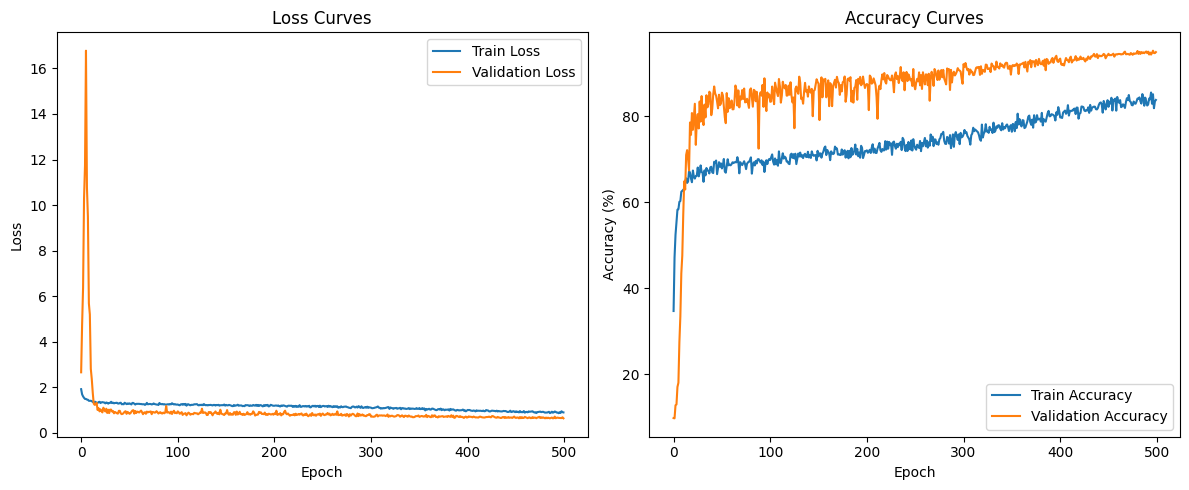

Generating predictions: 100%|██████████| 79/79 [00:02<00:00, 35.09it/s]


Submission file created: submission.csv


In [13]:
# Run Main Function (uncomment to execute)

if __name__ == "__main__":
    main()